# Load Packages

In [3]:
# Suppress unnecessary warnings
import warnings  
warnings.filterwarnings('ignore')  # Ignore warnings

# Data manipulation and analysis
import pandas as pd  

# Numerical operations
import numpy as np  

# Regular expressions for string operations
import re  

# Data visualisation
import matplotlib.pyplot as plt  # For stacked bar charts, histograms, etc.
import seaborn as sns  # For correlation matrices, etc.

# Geographical operations
from geopy.geocoders import Nominatim  # For working with postcodes
from geopy.distance import geodesic  # To calculate distances between geographical coordinates

# Statistical operations
from scipy.stats import ttest_ind  # For paired t-tests

# Model evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score  # General metrics
from sklearn.metrics import make_scorer, f1_score  # For F1 score calculation
from sklearn.metrics import precision_score, recall_score  # Precision and recall metrics

# Machine learning: Model training and evaluation
from sklearn.model_selection import train_test_split  # To split data into training and testing sets
from sklearn.model_selection import GridSearchCV  # For hyperparameter optimisation
from sklearn.linear_model import LogisticRegression  # For logistic regression modelling

# Import Data

In [5]:
# Define the path to the Excel file
file_path = r"C:\Users\vicky\OneDrive - Cardiff University\Desktop\MSc Data (1)\Dissertation\Myeloma Patient Admissions UHW 1-10-23 - 30-4-24.version 20-8-24.xlsx"

# Read the specified sheet with the header in the first two rows
df_hosp = pd.read_excel(file_path, sheet_name='Admitted Patients', header=[0, 1])

# Fill forward the first row to handle merged cells
first_row_filled = df_hosp.columns.get_level_values(0).tolist()
for i in range(len(first_row_filled)):
    if pd.isna(first_row_filled[i]):
        first_row_filled[i] = first_row_filled[i-1]

# Create new combined headers
combined_columns = []
for i in range(len(df_hosp.columns)):
    part1 = first_row_filled[i] if 'Unnamed' not in first_row_filled[i] else ''
    part2 = df_hosp.columns.get_level_values(1)[i] if 'Unnamed' not in df_hosp.columns.get_level_values(1)[i] else ''
    combined_columns.append(f"{part1} {part2}".strip())

# Assign the new headers to the dataframe
df_hosp.columns = combined_columns

# Read the specified sheet with the header in the first row
df_not = pd.read_excel(file_path, sheet_name='Non-Admitted Patients', header=0)

In [6]:
df_hosp.dtypes

Patient Number                                                                    int64
DOB                                                                              object
Gender                                                                           object
postcode                                                                         object
Ethnicity                                                                        object
Current Treatment Regime                           (Select from List)            object
Date of Admission                                                        datetime64[ns]
Day of week                                                                      object
Reason for Admission        (Select from List)                                   object
Date of Discharge                                                        datetime64[ns]
Length of Stay (days)                                                           float64
Outcome                         

# Combine Datasets

In [8]:
# Preprocess df_hosp
df_hosp['Treatment cycle number'] = df_hosp['Treatment cycle number'].replace('As above', pd.NA).fillna(method='ffill')
df_hosp['Number of cycles'] = df_hosp['Treatment cycle number'].str.extract(r'^(\d+)').fillna(0).astype(int)

# Remove prefix from column names in df_hosp
def remove_prefix(column_name, prefix="Pre admission Igs  "):
    if column_name.startswith(prefix):
        return column_name[len(prefix):]
    return column_name

df_hosp = df_hosp.rename(columns=lambda x: remove_prefix(x))

# Preprocess df_not
df_not['Number'] += 100
df_not['Hospitalised'] = 0
df_hosp['Hospitalised'] = 1

# Drop unnecessary columns from df_not
df_not = df_not.drop(columns=['Number.1', 'Diagnosis', 'Alive'])




# Standardise column names in df_not
df_not = df_not.rename(columns={
    'Number': 'Patient Number',
    'Comorbidities': 'Co-morbidities',
    'Line of therapy': 'Line of treatment',
    'Number of cycles (30th April 24)': 'Number of cycles',
    'PP (30/4/24)': 'PP',
    'Isotype': 'PP Type',
    'IgG': 'IgG (g/L)',
    'IgA': 'IgA (g/L)',
    'IgM': 'IgM (g/L)',
    'KLC': 'KLC (mg/L)',
    'LLC': 'LLC (mg/L)'
})

# Standardise column names in df_hosp
df_hosp = df_hosp.rename(columns={
    'Current Treatment Regime                           (Select from List)': 'Treatment',
    'postcode': 'Postcode',
    'Reason for Admission        (Select from List)': 'Reason for Admission',
    'PP Level': 'PP',
    'Baseline Neuts': 'Neuts',
    'PP  Type': 'PP Type',
})

In [9]:
# Get the column names for both dataframes
columns_hosp = set(df_hosp.columns)
columns_not = set(df_not.columns)

# Find the common columns
common_columns = columns_hosp.intersection(columns_not)

# Find columns specific to df_hosp
specific_columns_hosp = columns_hosp - columns_not

# Find columns specific to df_not
specific_columns_not = columns_not - columns_hosp

# Print the results
print("Common columns:")
print(common_columns)

print("\nColumns specific to Admitted Patients (df_hosp):")
print(specific_columns_hosp)

print("\nColumns specific to Non-Admitted Patients (df_not):")
print(specific_columns_not)

Common columns:
{'Patient Number', 'Treatment', 'IgG (g/L)', 'Ethnicity', 'Number of cycles', 'IgA (g/L)', 'Hospitalised', 'LLC (mg/L)', 'Co-morbidities', 'Line of treatment', 'Postcode', 'DOB', 'PP Type', 'PP', 'KLC (mg/L)', 'Neuts', 'IgM (g/L)', 'Gender'}

Columns specific to Admitted Patients (df_hosp):
{'Post admission/post discharge  Igs PP Type', 'DOD', 'PP Level.1', 'Post admission/post discharge  Igs IgG', 'Length of Stay (days)', 'Post admission/post discharge  Igs LLC', 'Antibiotic/Antiviral prophylaxis given', 'Treatment cycle number', 'Post admission/post discharge  Igs IgA', 'Outcome', 'Day of week', 'Survival Post Discharge', 'Post admission/post discharge  Igs KLC', 'Post admission/post discharge  Igs IgM', 'Date of Discharge', 'Reason for Admission', 'Date of Admission', 'Post admission/post discharge  Igs PP level'}

Columns specific to Non-Admitted Patients (df_not):
{'Ratio'}


In [10]:
# Combine the dataframes by stacking one underneath the other
df = pd.concat([df_hosp, df_not], ignore_index=True)

# Scrub

In [12]:
# Most of the times there is no change or little change, so post value will be used if there is no pre value, being it the best approximation.
df[['Patient Number','IgG (g/L)','Post admission/post discharge  Igs IgG', 'IgA (g/L)', 'Post admission/post discharge  Igs IgA','IgM (g/L)', 'Post admission/post discharge  Igs IgM',
    'KLC (mg/L)','Post admission/post discharge  Igs KLC', 'LLC (mg/L)', 'Post admission/post discharge  Igs LLC']]

,Patient Number,IgG (g/L),Post admission/post discharge Igs IgG,IgA (g/L),Post admission/post discharge Igs IgA,IgM (g/L),Post admission/post discharge Igs IgM,KLC (mg/L),Post admission/post discharge Igs KLC,LLC (mg/L),Post admission/post discharge Igs LLC
0,5,5.97,5.16,1.97,1.72,0.83,0.91,26.37,29.39,18.55,23.68
1,8,5.76,12.02,1.67,2.74,1.09,0.99,28.56,83.1,22.75,40.8
2,11,NaN,NaN,1.09,0.41,0.26,0.18,91.42,12.33,12.15,8.42
3,7,4.49,NaN,0.98,NaN,0.32,NaN,10.40,NaN,18.35,NaN
4,9,5.52,6.49,0.25,0.55,0.52,0.39,9.92,25.71,9.23,22.97
...,...,...,...,...,...,...,...,...,...,...,...
140,191,10.46,NaN,3.1,NaN,0.65,NaN,26.30,NaN,26.7,NaN
141,192,10.41,NaN,0.07,NaN,<0.1,NaN,23.90,NaN,5.7,NaN
142,193,10.31,NaN,1.19,NaN,0.67,NaN,6.60,NaN,4,NaN
143,194,10.45,NaN,3.09,NaN,0.2,NaN,39.20,NaN,36.1,NaN


In [13]:
# Define a list of column pairs: pre and post columns that need processing, excluding 'PP'
column_pairs = [
    ('PP Type', 'Post admission/post discharge  Igs PP Type'),
    ('IgG (g/L)', 'Post admission/post discharge  Igs IgG'),
    ('IgA (g/L)', 'Post admission/post discharge  Igs IgA'),
    ('IgM (g/L)', 'Post admission/post discharge  Igs IgM'),
    ('KLC (mg/L)', 'Post admission/post discharge  Igs KLC'),
    ('LLC (mg/L)', 'Post admission/post discharge  Igs LLC')
]

# Define a function to process columns based on the column pairs
def process_columns(df, column_pairs):
    for pre_col, post_col in column_pairs:
        # Step 1: Replace NaN values in the pre column with values from the post column
        df[pre_col] = df.apply(
            lambda row: row[post_col] if pd.isna(row[pre_col]) else row[pre_col],
            axis=1)

        # Step 2: Fill NaN values in the pre column with non-NaN values from the same 'Patient Number'
        patient_values = df.groupby('Patient Number')[pre_col].apply(lambda x: x.dropna().unique()).to_dict()
        
        df[pre_col] = df.apply(
            lambda row: patient_values.get(row['Patient Number'], [np.nan])[0] 
            if pd.isna(row[pre_col]) and len(patient_values.get(row['Patient Number'], [])) > 0
            else row[pre_col],
            axis=1)

        # Step 3: Replace any remaining empty lists ('[]') with NaN
        df[pre_col] = df[pre_col].replace('[]', np.nan)
        
        # Convert the column to a string type if necessary and strip any leading/trailing whitespace
        if df[pre_col].dtype == 'object':
            df[pre_col] = df[pre_col].astype(str).str.strip()
    
    return df

# Apply the process_columns function to handle all relevant columns
df = process_columns(df, column_pairs)

# Display the final DataFrame with updated columns
df[['Patient Number','IgG (g/L)','Post admission/post discharge  Igs IgG', 'IgA (g/L)', 'Post admission/post discharge  Igs IgA','IgM (g/L)', 'Post admission/post discharge  Igs IgM',
    'KLC (mg/L)','Post admission/post discharge  Igs KLC', 'LLC (mg/L)', 'Post admission/post discharge  Igs LLC']]

,Patient Number,IgG (g/L),Post admission/post discharge Igs IgG,IgA (g/L),Post admission/post discharge Igs IgA,IgM (g/L),Post admission/post discharge Igs IgM,KLC (mg/L),Post admission/post discharge Igs KLC,LLC (mg/L),Post admission/post discharge Igs LLC
0,5,5.97,5.16,1.97,1.72,0.83,0.91,26.37,29.39,18.55,23.68
1,8,5.76,12.02,1.67,2.74,1.09,0.99,28.56,83.1,22.75,40.8
2,11,NaN,NaN,1.09,0.41,0.26,0.18,91.42,12.33,12.15,8.42
3,7,4.49,NaN,0.98,NaN,0.32,NaN,10.40,NaN,18.35,NaN
4,9,5.52,6.49,0.25,0.55,0.52,0.39,9.92,25.71,9.23,22.97
...,...,...,...,...,...,...,...,...,...,...,...
140,191,10.46,NaN,3.1,NaN,0.65,NaN,26.30,NaN,26.7,NaN
141,192,10.41,NaN,0.07,NaN,<0.1,NaN,23.90,NaN,5.7,NaN
142,193,10.31,NaN,1.19,NaN,0.67,NaN,6.60,NaN,4,NaN
143,194,10.45,NaN,3.09,NaN,0.2,NaN,39.20,NaN,36.1,NaN


Re-calculate Ratio column as it is not present in the hospitalised dataset.

In [15]:
df['Ratio']

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
      ... 
140    1.0
141    4.2
142    1.7
143    1.1
144    2.5
Name: Ratio, Length: 145, dtype: float64

In [16]:
# Convert columns to numeric, coercing errors into NaNs
df['KLC (mg/L)'] = pd.to_numeric(df['KLC (mg/L)'], errors='coerce')
df['LLC (mg/L)'] = pd.to_numeric(df['LLC (mg/L)'], errors='coerce')

# Calculate the ratio and handle potential division by zero
df['Ratio'] = df['KLC (mg/L)'] / df['LLC (mg/L)']

# Replace infinite or NaN values resulting from division by zero
df['Ratio'].replace([np.inf, -np.inf], np.nan, inplace=True)

In [17]:
df['Ratio']

0      1.421563
1      1.255385
2      7.524280
3      0.566757
4      1.074756
         ...   
140    0.985019
141    4.192982
142    1.650000
143    1.085873
144    2.469388
Name: Ratio, Length: 145, dtype: float64

In [18]:
# Function to parse and standardise date formats
def parse_date(date_str):
    if isinstance(date_str, pd.Timestamp):
        return date_str.date()
    elif isinstance(date_str, str):
        date_str = date_str.strip()
        try:
            # Attempt to parse the date string with common formats
            return pd.to_datetime(date_str, errors='coerce').date()
        except ValueError:
            return pd.NaT
    return pd.NaT

# Standardise 'DOB' and 'Date of Admission', ensuring no time components
df['DOB'] = df['DOB'].apply(parse_date).pipe(pd.to_datetime, errors='coerce').dt.normalize()
df['Date of Admission'] = pd.to_datetime(df['Date of Admission'], errors='coerce')

# Define default date and calculate 'Age' using default date for missing 'Date of Admission'
default_date = pd.Timestamp('2024-04-30')
df['Age'] = df.apply(
    lambda row: ((default_date if pd.isna(row['Date of Admission']) else row['Date of Admission']) - row['DOB']).days // 365, axis=1)

# Display the cleaned 'DOB' and 'Age' columns
df[['DOB', 'Age']]

,DOB,Age
0,NaT,NaN
1,1948-08-14,75.0
2,1940-07-02,83.0
3,1949-04-02,75.0
4,1972-01-15,51.0
...,...,...
140,1955-08-18,68.0
141,1960-12-04,63.0
142,1956-10-06,67.0
143,1959-01-26,65.0


# Process "Co-morbidities" column

in the "Co-morbidities" column some work shall be done with the strings.

Replace "T2DM" and "Type 2 diabetes mellitus" and "diabetes", by "Diabetes"

Replace "Depression NOS" and "depression", by "Depression"

Replace "COPD" and "Chronic obstructive airways disease" with "Chronic obstructive pulmonary disease"

"Hypertensive" by ""Hypertension"

Create co-morbidities categories, and one-hot-encodding shall be done with that

In [22]:
# Fill NaN values with empty string
df['Co-morbidities'] = df['Co-morbidities'].fillna('')

# Define mappings from conditions to categories including "Mental disorders"
condition_to_category = {
    'atopy': 'Allergy',
    'rheumatoid arthritis': 'Autoimmune',
    'vasculitis': 'Autoimmune',
    'acute non-st segment elevation myocardial': 'Cardiovascular Diseases',
    'acute non-st segment elevation myocardial infarction': 'Cardiovascular Diseases',
    'atrial fibrillation': 'Cardiovascular Diseases',
    'deep vein thrombosis': 'Cardiovascular Diseases',
    'diastolic dysfunction': 'Cardiovascular Diseases',
    'essential hypertension': 'Cardiovascular Diseases',
    'essential hypertension atrial fibrillation': 'Cardiovascular Diseases',
    'heart failure': 'Cardiovascular Diseases',
    'htn': 'Cardiovascular Diseases',
    'hypertension': 'Cardiovascular Diseases',
    'infarction': 'Cardiovascular Diseases',
    'ischaemic heart disease': 'Cardiovascular Diseases',
    'lvf': 'Cardiovascular Diseases',
    'myocardial infarction': 'Cardiovascular Diseases',
    'atrial fibrillation and flutter': 'Cardiovascular Diseases',
    'benign prostatic hypertrophycongestive cardiac failure': 'Cardiovascular Diseases',
    'hypertensive disease': 'Cardiovascular Diseases',
    'deep vein thrombosis': 'Cardiovascular Diseases',
    'depression': 'Mental Health Disorders',
    'depression nos': 'Mental Health Disorders',
    'depressive disorder': 'Mental Health Disorders',
    'anxiety with depression': 'Mental Health Disorders',
    'panic disorder': 'Mental Health Disorders',
    'acquired hypothyroidism': 'Endocrine and Metabolic Disorders',
    'diabetic retinopathy': 'Endocrine and Metabolic Disorders',
    'hyperlipidaemia nos': 'Endocrine and Metabolic Disorders',
    'hypothyroidism': 'Endocrine and Metabolic Disorders',
    'mixed hyperlipidaemia': 'Endocrine and Metabolic Disorders',
    'subclinical hypothyroidism': 'Endocrine and Metabolic Disorders',
    'gynaecomastia': 'Endocrine and Metabolic Disorders',
    'hyperparathyroidism': 'Endocrine and Metabolic Disorders',
    'thyroid cancer': 'Cancer, Endocrine and Metabolic Disorders',
    'thyrotoxicosis': 'Endocrine and Metabolic Disorders',
    'vitamin d insufficiency': 'Endocrine and Metabolic Disorders',
    'diabetes insipidus': 'Endocrine and Metabolic Disorders',
    'subclinical hyperthyroidism': 'Endocrine and Metabolic Disorders',
    'diabetes': 'Diabetes',
    'diabetes type 2': 'Diabetes',
    'dm': 'Diabetes',
    't2dm': 'Diabetes',
    'type 2 diabetes': 'Diabetes',
    'type 2 diabetes mellitus': 'Diabetes',
    'pre-diabetes': 'Diabetes',
    'mixed hyperlipidaemia type 2 diabetes mellitus': 'Endocrine and Metabolic Disorders, Diabetes',
    'arthritis': 'Musculoskeletal Disorders',
    'arthropathy nos': 'Musculoskeletal Disorders',
    'fracture nos': 'Musculoskeletal Disorders',
    'gout': 'Musculoskeletal Disorders',
    'knee osteoarthritis nos': 'Musculoskeletal Disorders',
    'low back': 'Musculoskeletal Disorders',
    'low back pain': 'Musculoskeletal Disorders',
    'multiple previous fractures spine': 'Musculoskeletal Disorders',
    'osteoarthritis': 'Musculoskeletal Disorders',
    'osteoporosis': 'Musculoskeletal Disorders',
    'pain': 'Musculoskeletal Disorders',
    'cataract cervical spondylosis': 'Eye Disorders, Musculoskeletal Disorders',
    'irritable bowel syndrome osteoporosis': 'Digestive Disorders, Musculoskeletal Disorders',
    'psoriasis': 'Skin Disorders',
    'actinic keratosis': 'Skin Disorders',
    'acne vulgaris': 'Skin Disorders',
    'atopic dermatitis/eczema': 'Skin Disorders',
    'basal cell carcinoma': 'Skin Disorders',
    'basal cell carcinoma of skin': 'Skin Disorders',
    'eczema': 'Skin Disorders',
    'pyogenic granuloma': 'Skin Disorders',
    'seborrhoeic eczema': 'Skin Disorders',
    'squamous cell carcinoma of skin': 'Skin Disorders',
    'asthma': 'Respiratory Diseases',
    'bronchiectasis': 'Respiratory Diseases',
    'bronchitis': 'Respiratory Diseases',
    'chronic obstructive airways disease': 'Respiratory Diseases',
    'copd': 'Respiratory Diseases',
    'pulmonary embolism': 'Respiratory Diseases',
    'pulmonary embolism gout': 'Respiratory Diseases, Musculoskeletal Disorders',
    'cva unspecified': 'Neurological Disorders',
    'epilepsy': 'Neurological Disorders',
    'migraine': 'Neurological Disorders',
    'previous stroke': 'Neurological Disorders',
    'sciatica': 'Neurological Disorders',
    'shingles': 'Neurological Disorders',
    'meniere\'s disease': 'Ear Disorders',
    'glaucoma': 'Eye Disorders',
    'cataract': 'Eye Disorders',
    'chronic urinary infection': 'Digestive Disorders',
    'chronic urinary tract infections': 'Digestive Disorders',
    'diverticulitis': 'Digestive Disorders',
    'diverticulosis': 'Digestive Disorders',
    'diverticular disease': 'Digestive Disorders',
    'gastro-oesophageal reflux': 'Digestive Disorders',
    'irritable bowel syndrome': 'Digestive Disorders',
    'dyspepsia': 'Digestive Disorders',
    'infective hepatitis': 'Liver Disorders',
    'itp': 'Haematological Disorders',
    'monocytosis': 'Haematological Disorders',
    'essential (haemorrhagic) thrombocythaemia': 'Haematological Disorders',
    'chronic kidney disease stage 3': 'Kidney Disorders',
    'injury to kidney': 'Kidney Disorders',
    'kidney failure': 'Kidney Disorders',
    'lumpy breasts': 'Breast Disorders',
    'alcohol excess': 'Substance Abuse Disorders',
    'erectile dysfunction': 'Urological and Reproductive Disorders',
    'epididymal cyst': 'Urological and Reproductive Disorders',
    'bph': 'Urological and Reproductive Disorders',
    'malig neop of kidney and other unspecified urinary organs': 'Cancer, Urological and Reproductive Disorders',
    'prior testicular carcinoma and papillary thyroid tumour': 'Urological and Reproductive Disorders, Endocrine and Metabolic Disorders',
    'malignant neoplasm of cervix uteri': 'Cancer, Urological and Reproductive Disorders',
    'testicular cancer': 'Cancer, Urological and Reproductive Disorders',
    'uterine leiomyoma - fibroids': 'Urological and Reproductive Disorders',
    'uterine prolapse': 'Urological and Reproductive Disorders',
    'varicocele': 'Urological and Reproductive Disorders'
}


# Function to map conditions to categories
def map_to_category(condition):
    categories = []
    # Split by new line and clean up extra spaces and periods
    conditions = re.split(r'\n+', condition)
    conditions = [re.sub(r'[.\s]+', ' ', c).strip().lower() for c in conditions if c.strip()]
    
    for cond in conditions:
        # Split by comma, treat each part as a separate condition, and eliminate any blank conditions
        sub_conditions = [sub_cond.strip(',').strip() for sub_cond in re.split(r',\s*', cond) if sub_cond.strip()]
        for sub_cond in sub_conditions:
            if sub_cond in ['dm', 't2dm', 'type 2 diabetes mellitus', 'diabetes type 2']:
                categories.append('Diabetes')
            elif sub_cond in ['hypertensive', 'hypertensive disease']:
                categories.append('Cardiovascular Diseases')
            else:
                categories.append(condition_to_category.get(sub_cond, 'Other'))
    
    return categories

# Apply mapping function to create new column
df['Category'] = df['Co-morbidities'].apply(map_to_category)

In [23]:
# Print the DataFrame
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None) 
df[['Patient Number','Co-morbidities', 'Category']]

,Patient Number,Co-morbidities,Category
0,5,Hyperlipidaemia NOS \nHypertensive disease \nEssential hypertension\nLumpy breasts,"[Endocrine and Metabolic Disorders, Cardiovascular Diseases, Cardiovascular Diseases, Breast Disorders]"
1,8,atrial fibrillation \nOsteoarthritis \nEssential hypertension,"[Cardiovascular Diseases, Musculoskeletal Disorders, Cardiovascular Diseases]"
2,11,diabetic retinopathy \nVaricocele\nEpididymal cyst \nMixed hyperlipidaemia Type 2 diabetes mellitus \nBronchiectasis,"[Endocrine and Metabolic Disorders, Urological and Reproductive Disorders, Urological and Reproductive Disorders, Endocrine and Metabolic Disorders, Diabetes, Respiratory Diseases]"
3,7,,[]
4,9,Chronic kidney disease stage 3\nerectile dysfunction \nEssential hypertension\nLow back pain,"[Kidney Disorders, Urological and Reproductive Disorders, Cardiovascular Diseases, Musculoskeletal Disorders]"
5,10,Previous stroke\nHypertensive disease \nEssential hypertension\nLumpy breasts,"[Neurological Disorders, Cardiovascular Diseases, Cardiovascular Diseases, Breast Disorders]"
6,16,\tPrior testicular carcinoma and papillary thyroid tumour,"[Urological and Reproductive Disorders, Endocrine and Metabolic Disorders]"
7,18,Heart failure \nAcute non-ST segment elevation myocardial \ninfarction\nOsteoporosis \nFracture NOS,"[Cardiovascular Diseases, Cardiovascular Diseases, Cardiovascular Diseases, Musculoskeletal Disorders, Musculoskeletal Disorders]"
8,4,Hypertensive,[Cardiovascular Diseases]
9,24,"Diabetes, ischaemic heart disease, depression","[Diabetes, Cardiovascular Diseases, Mental Health Disorders]"


In [24]:
# Manually fix the problematic combined categories
def fix_combined_categories(categories):
    fixed_categories = []
    for category in categories:
        if category == 'Endocrine and Metabolic Disorders, Diabetes':
            fixed_categories.extend(['Endocrine and Metabolic Disorders', 'Diabetes'])
        elif category == 'Digestive Disorders, Musculoskeletal Disorders':
            fixed_categories.extend(['Digestive Disorders', 'Musculoskeletal Disorders'])
        elif category == 'Cancer, Endocrine and Metabolic Disorders':
            fixed_categories.extend(['Cancer', 'Endocrine and Metabolic Disorders'])
        elif category == 'Cancer, Urological and Reproductive Disorders':
            fixed_categories.extend(['Cancer', 'Urological and Reproductive Disorders'])
        else:
            fixed_categories.append(category)
    return fixed_categories

# Ensure 'Category' column is a list of strings split by comma and remove extra spaces
df['Category'] = df['Category'].apply(lambda x: [item.strip() for item in x[0].split(',')] if isinstance(x, list) and len(x) == 1 else x)

# Apply the manual fix to the combined categories
df['Category'] = df['Category'].apply(fix_combined_categories)

# Create a set of unique categories
category_columns = set(category for row in df['Category'] for category in row)

# Create columns for each category with count
for category in category_columns:
    df[category] = df['Category'].apply(lambda x: x.count(category))

In [25]:
pd.set_option('display.max_columns', None)
df.tail()

,Patient Number,DOB,Gender,Postcode,Ethnicity,Treatment,Date of Admission,Day of week,Reason for Admission,Date of Discharge,Length of Stay (days),Outcome,DOD,Survival Post Discharge,Treatment cycle number,Line of treatment,IgG (g/L),IgA (g/L),IgM (g/L),KLC (mg/L),LLC (mg/L),PP Type,PP,PP Level.1,Post admission/post discharge Igs IgG,Post admission/post discharge Igs IgA,Post admission/post discharge Igs IgM,Post admission/post discharge Igs KLC,Post admission/post discharge Igs LLC,Post admission/post discharge Igs PP Type,Post admission/post discharge Igs PP level,Neuts,Antibiotic/Antiviral prophylaxis given,Co-morbidities,Number of cycles,Hospitalised,Ratio,Age,Category,Substance Abuse Disorders,Respiratory Diseases,Musculoskeletal Disorders,Eye Disorders,Liver Disorders,Ear Disorders,Neurological Disorders,Breast Disorders,Endocrine and Metabolic Disorders,Cardiovascular Diseases,Autoimmune,Digestive Disorders,Mental Health Disorders,Cancer,Skin Disorders,Kidney Disorders,Diabetes,Allergy,Haematological Disorders,Urological and Reproductive Disorders
140,191,1955-08-18,M,CF3 2TH,Caucasian,IRD,NaT,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,2nd,10.46,3.1,0.65,26.3,26.7,IgG Kappa,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.2,NaN,Type 2 diabetes mellitus,35,0,0.985019,68.0,[Diabetes],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
141,192,1960-12-04,M,CF64 4JJ,Caucasian,DPD,NaT,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,4th,10.41,0.07,<0.1,23.9,5.7,IgA kappa,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.7,NaN,Essential hypertension,9,0,4.192982,63.0,[Cardiovascular Diseases],0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
142,193,1956-10-06,M,CF3 2TN,Caucasian,Len maintenance,NaT,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,1st,10.31,1.19,0.67,6.6,4.0,IgG Kappa,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.6,NaN,Essential hypertension,10,0,1.650000,67.0,[Cardiovascular Diseases],0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
143,194,1959-01-26,F,CF11 8ES,Caucasian,Len/Dex,NaT,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,1st,10.45,3.09,0.2,39.2,36.1,IgG Kappa,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.3,NaN,"Asthma,",28,0,1.085873,65.0,[Respiratory Diseases],0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
144,195,1964-11-17,M,CF14 1LU,Caucasian,Len maintenance,NaT,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,1st,8.27,1.44,0.13,12.1,4.9,IgG Kappa,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.1,NaN,Atrial fibrillation and flutter,16,0,2.469388,59.0,[Cardiovascular Diseases],0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [26]:
# Regular expression for the required postcode formats
postcode_regex = r'^[A-Z]{2}\d{1,2}\s\d[A-Z]{2}$'

# Check which postcodes do not match the format
invalid_postcodes = df[~df['Postcode'].str.match(postcode_regex, na=False)]

# Print invalid postcodes
print("Invalid Postcodes:")
print(invalid_postcodes['Postcode'])

# Function to fix the postcodes
def fix_postcode(postcode):
    if pd.isna(postcode):
        return postcode
    postcode = postcode.strip().upper()
    
    # Remove '0' after 'CF'
    if postcode.startswith('CF0'):
        postcode = 'CF' + postcode[3:]
    
    # Format postcodes
    if len(postcode) == 6 and postcode[3] != ' ':
        return f"{postcode[:3]} {postcode[3:]}"
    elif len(postcode) == 7 and postcode[4] != ' ':
        return f"{postcode[:4]} {postcode[4:]}"
    elif postcode.startswith(r'\t'):
        return postcode.lstrip(r'\t')
    else:
        return postcode

# Apply the function to the Postcode column
df['Postcode_fixed'] = df['Postcode'].apply(fix_postcode)

df[['Postcode', 'Postcode_fixed']]


Invalid Postcodes:
11         CF33PJ
14         CF33NW
15      \tCF5 4FA
22     \tCF64 2SL
23      \tCF3 3LX
44      \tCF3 0EA
47      \tCF3 0EA
54         CF54HX
56        CF645TD
59            NaN
66        CF626RW
106       CF453DN
120       CF645TG
124       CF236PX
Name: Postcode, dtype: object


,Postcode,Postcode_fixed
0,CF5 1EG,CF5 1EG
1,CF23 9HY,CF23 9HY
2,CF14 3EF,CF14 3EF
3,CF23 9BB,CF23 9BB
4,CF62 5DA,CF62 5DA
5,CF11 9JN,CF11 9JN
6,CF3 0AL,CF3 0AL
7,CF5 4NS,CF5 4NS
8,CF61 2SD,CF61 2SD
9,CF23 9NP,CF23 9NP


In [27]:
df['Postcode_fixed']

0      CF5  1EG
1      CF23 9HY
2      CF14 3EF
3      CF23 9BB
4      CF62 5DA
5      CF11 9JN
6      CF3  0AL
7      CF5  4NS
8      CF61 2SD
9      CF23 9NP
10     CF23 9NP
11      CF3 3PJ
12     CF14 0UJ
13     CF61 2SD
14      CF3 3NW
15     CF5  4FA
16     CF14 1NW
17     CF62 9PW
18     NP4  7EP
19     CF4  3LW
20     CF4  3LW
21     CF4  3LW
22     CF64 2SL
23     CF3  3LX
24     CF62 8BT
25     CF62 4QB
26     CF62 4QB
27     CF4  3LW
28     CF4  3LW
29     CF4  3LW
30     CF3  0AL
31     CF14 1JZ
32     CF14 2JQ
33     CF83 1PF
34     CF61 2LS
35     CF14 9EH
36     CF62 9XN
37     CF14 0AU
38     CF24 3RZ
39     CF14 0AX
40     CF14 1NW
41     CF10 2GP
42     CF11 9JN
43     CF3  0AL
44     CF3  0EA
45     CF14 7BX
46     CF14 4NU
47     CF3  0EA
48     CF24 3RZ
49     CF24 3RZ
50     CF10 4RH
51     CF64 4JN
52     SA2  8BQ
53     NP12 1GF
54      CF5 4HX
55     CF24 2HN
56     CF64 5TD
57     NP12 3NN
58     CF62 3LB
59          NaN
60     CF62 7HR
61     CF23 6DE
62     C

CF4 3 postcodes are no longer in use.
CF4 3LW is Latitude: 51.498539  Longitude: -3.185559

CF4 9 postcodes Cardiff (no longer in use)

In [29]:
# Initialise the geocoder
geolocator = Nominatim(user_agent="postcode_geocoder")

# Cache dictionary to store coordinates for postcodes
cache = {
    'CF4  3LW': (51.498539, -3.185559),
    'CF4  9AH': (51.536119, -3.203837)
}

# Function to validate and get coordinates of a postcode
def get_coordinates(postcode):
    # Standardize the postcode format
    postcode = postcode.strip().upper()
    
    # Check if postcode is in the cache
    if postcode in cache:
        return cache[postcode]
    
    if not isinstance(postcode, str) or pd.isna(postcode) or postcode == '':
        return (None, None)
    
    # Query the coordinates
    location = geolocator.geocode(postcode + ", UK")
    if location is None:
        coords = (None, None)
    else:
        coords = (location.latitude, location.longitude)
    
    # Store the result in the cache
    cache[postcode] = coords
    return coords

# Function to calculate distance between two postcodes
def calculate_distance(postcode1, postcode2):
    coords_1 = get_coordinates(postcode1)
    coords_2 = get_coordinates(postcode2)
    
    if None in coords_1 or None in coords_2:
        return None
    
    return geodesic(coords_1, coords_2).kilometers

# Define the reference postcode
reference_postcode = 'CF14 4XW'  # UHW postcode

# Create new columns for latitude, longitude, and distance
df['Latitude'] = df['Postcode_fixed'].apply(lambda x: get_coordinates(x)[0] if isinstance(x, str) and x.strip() != '' else None)
df['Longitude'] = df['Postcode_fixed'].apply(lambda x: get_coordinates(x)[1] if isinstance(x, str) and x.strip() != '' else None)
df['Distance from UHW'] = df.apply(lambda row: calculate_distance(row['Postcode_fixed'], reference_postcode) if pd.notna(row['Latitude']) and pd.notna(row['Longitude']) else None, axis=1)

# Display the DataFrame
print(df[['Postcode_fixed', 'Latitude', 'Longitude', 'Distance from UHW']])

    Postcode_fixed   Latitude  Longitude  Distance from UHW
0         CF5  1EG  51.483923  -3.217162           3.130969
1         CF23 9HY  51.506500  -3.158560           2.333052
2         CF14 3EF  51.502394  -3.199850           0.767174
3         CF23 9BB  51.499450  -3.149350           3.097585
4         CF62 5DA  51.391350  -3.268850          13.962257
5         CF11 9JN  51.489400  -3.199550           2.060302
6         CF3  0AL  51.522120  -3.110140           5.925098
7         CF5  4NS  51.475350  -3.257720           5.779992
8         CF61 2SD  51.413280  -3.481330          22.659825
9         CF23 9NP  51.517050  -3.147410           3.287909
10        CF23 9NP  51.517050  -3.147410           3.287909
11         CF3 3PJ  51.512930  -3.116960           5.256187
12        CF14 0UJ  51.545090  -3.179390           4.293148
13        CF61 2SD  51.413280  -3.481330          22.659825
14         CF3 3NW  51.512710  -3.120780           4.989968
15        CF5  4FA  51.481310  -3.246010

In [30]:
df['Distance from UHW'].describe()

count    144.000000
mean       9.675435
std       12.881207
min        0.767174
25%        2.957075
50%        5.107699
75%       12.210234
max       87.379165
Name: Distance from UHW, dtype: float64

In [31]:
# Calculate the median of the 'Distance from UHW' column
median_distance = df['Distance from UHW'].median()

# Assign the median value to the NaN values in the 'Distance from UHW' column
df['Distance from UHW'].fillna(median_distance, inplace=True)

# Display the DataFrame to verify the changes
print(df[['Postcode', 'Postcode_fixed', 'Latitude', 'Longitude', 'Distance from UHW']])


       Postcode Postcode_fixed   Latitude  Longitude  Distance from UHW
0       CF5 1EG       CF5  1EG  51.483923  -3.217162           3.130969
1      CF23 9HY       CF23 9HY  51.506500  -3.158560           2.333052
2      CF14 3EF       CF14 3EF  51.502394  -3.199850           0.767174
3      CF23 9BB       CF23 9BB  51.499450  -3.149350           3.097585
4      CF62 5DA       CF62 5DA  51.391350  -3.268850          13.962257
5      CF11 9JN       CF11 9JN  51.489400  -3.199550           2.060302
6       CF3 0AL       CF3  0AL  51.522120  -3.110140           5.925098
7       CF5 4NS       CF5  4NS  51.475350  -3.257720           5.779992
8      CF61 2SD       CF61 2SD  51.413280  -3.481330          22.659825
9      CF23 9NP       CF23 9NP  51.517050  -3.147410           3.287909
10     CF23 9NP       CF23 9NP  51.517050  -3.147410           3.287909
11       CF33PJ        CF3 3PJ  51.512930  -3.116960           5.256187
12     CF14 0UJ       CF14 0UJ  51.545090  -3.179390           4

In [36]:
df['PP Type'].unique()

array(['IgG Kappa\nIgG lambda\nIgM kappa\n on IF',
       'IgG Kappa\nIgG lambda\n on IF', 'IgG Kappa', 'B2M',
       'IgG Kappa\nIgG lambda on IF', 'IgG Kappa\nIgM Kappa\nIgG Lambda',
       'IgG Lambda', 'IgA Lambda', 'IgA lambda\nFLLC',
       'Free lambda on IF',
       'IgA lambda band 1\nIgA lambda band 2\nIgG Kappa', 'IgG lambda',
       'IgM kappa band', 'nan', 'IgG Kappa on IF', 'IgA kappa',
       'IgG Kappa\nIgG Lambda', 'IgA lambda', 'FLLC only',
       'Light Chain (K)', 'Free Kappa', 'IgA Kappa', 'Free Lambda',
       'IgGKappa', 'Light Chain', 'Lambda LC 277 PP in progress',
       'IgG Lambda and Kappa', 'IgD Lambda', 'IgM Kappa', 'Lambda',
       'Non Secretory', 'IgA', 'Kappa'], dtype=object)

In [37]:
# Create a copy of 'PP Type'
df['PP Type Copy'] = df['PP Type']

# Step 1: Replace 'band 1' and 'band 2' from the copied column
df['PP Type Copy'] = df['PP Type Copy'].astype(str)  # Ensure the column is treated as string

# Replace specific substrings in the copied column

df['PP Type Copy'] = df['PP Type Copy'].fillna('')  # Replace NaN with empty string

df['PP Type Copy'] = df['PP Type Copy'].replace('IgG Kappa\nIgG lambda\nIgM kappa\n on IF', 'IgG\nIgG\nIgM')
df['PP Type Copy'] = df['PP Type Copy'].str.replace(' band 1', '', regex=False)
df['PP Type Copy'] = df['PP Type Copy'].str.replace(' band 2', '', regex=False)

# Remove extra commas and spaces
df['PP Type Copy'] = df['PP Type Copy'].str.replace(', ,', ',', regex=False)
df['PP Type Copy'] = df['PP Type Copy'].str.strip()

df['PP Type Copy'] = df['PP Type Copy'].str.lower()

# Define replacement mappings
replacements = {
    'fllc only': 'fllc',
    'igm kappa on if': 'igm',
    'igg kappa on if': 'igg',
    'igg lambda on if': 'igg',
    'free lambda on if': 'free',
    'igm kappa band': 'igm',
    'light chain (k)': 'light chain',
    'lambda lc 277 pp in progress': 'lambda',
    'igg lambda and kappa': ['igg', 'igg'],
    'igg kappa\nigg lambda\n on if' : ['igg', 'igg'],
    ' kappa': '',
    ' lambda': '',
    'free': 'light chain', # from literature review on types of myeloma
    'fllc': 'light chain', #  free lambda light chain (FLLC)
    'lambda': 'light chain',
    'kappa': 'light chain',
    'nan': ''
}

# Apply replacements for simple cases
for old, new in replacements.items():
    if isinstance(new, str):
        df['PP Type Copy'] = df['PP Type Copy'].str.replace(old, new, case=False, regex=False)
    elif isinstance(new, list):
        df['PP Type Copy'] = df['PP Type Copy'].str.replace(old, '\n'.join(new), case=False, regex=False)



# Step 2: Convert cleaned strings into lists where \n are separators
df['PP Type Copy'] = df['PP Type Copy'].str.split('\n')  # Split on comma with optional whitespace

df[['PP Type','PP Type Copy']] 

,PP Type,PP Type Copy
0,IgG Kappa\nIgG lambda\nIgM kappa\n on IF,"[igg, igg, igm]"
1,IgG Kappa\nIgG lambda\n on IF,"[igg, igg]"
2,IgG Kappa,[igg]
3,B2M,[b2m]
4,IgG Kappa\nIgG lambda on IF,"[igg, igg]"
5,IgG Kappa\nIgM Kappa\nIgG Lambda,"[igg, igm, igg]"
6,IgG Kappa,[igg]
7,IgG Lambda,[igg]
8,IgA Lambda,[iga]
9,IgG Kappa,[igg]


In [38]:
# Flatten the lists in 'PP Type' and expand to a new DataFrame
df_flat = df.explode('PP Type Copy')

# Perform one-hot encoding and convert boolean values to integers (1 and 0)
one_hot = pd.get_dummies(df_flat['PP Type Copy']).astype(int)

# Combine the one-hot encoded DataFrame with the flattened DataFrame
df_encoded = df_flat.join(one_hot)

# Aggregate the one-hot encoding back into the original rows
df_encoded = df_encoded.groupby(df_encoded.index).max().reset_index(drop=True)

# Drop columns from df_encoded that are already in df
existing_columns = set(df.columns)
new_columns_to_keep = [col for col in df_encoded.columns if col not in existing_columns]

# Merge only the new columns with the original DataFrame
df = pd.concat([df, df_encoded[new_columns_to_keep]], axis=1)

# Remove columns with empty headers (i.e., columns with empty strings as their names)
df = df.loc[:, df.columns != '']

# Print the final DataFrame
df

,Patient Number,DOB,Gender,Postcode,Ethnicity,Treatment,Date of Admission,Day of week,Reason for Admission,Date of Discharge,Length of Stay (days),Outcome,DOD,Survival Post Discharge,Treatment cycle number,Line of treatment,IgG (g/L),IgA (g/L),IgM (g/L),KLC (mg/L),LLC (mg/L),PP Type,PP,PP Level.1,Post admission/post discharge Igs IgG,Post admission/post discharge Igs IgA,Post admission/post discharge Igs IgM,Post admission/post discharge Igs KLC,Post admission/post discharge Igs LLC,Post admission/post discharge Igs PP Type,Post admission/post discharge Igs PP level,Neuts,Antibiotic/Antiviral prophylaxis given,Co-morbidities,Number of cycles,Hospitalised,Ratio,Age,Category,Substance Abuse Disorders,Respiratory Diseases,Musculoskeletal Disorders,Eye Disorders,Liver Disorders,Ear Disorders,Neurological Disorders,Breast Disorders,Endocrine and Metabolic Disorders,Cardiovascular Diseases,Autoimmune,Digestive Disorders,Mental Health Disorders,Cancer,Skin Disorders,Kidney Disorders,Diabetes,Allergy,Haematological Disorders,Urological and Reproductive Disorders,Postcode_fixed,Latitude,Longitude,Distance from UHW,PP Type Copy,b2m,iga,igd,igg,igglight chain,igm,light chain,non secretory
0,5,NaT,Male,CF5 1EG,Caucasian,Not on Treatment,2023-11-07,Tue,Tempurature / Infection,2023-12-12,35.0,Home,2023-12-17 00:00:00,5.0,Off treatment - palliative,4 previously,5.970000,1.970000,0.830000,26.370000,18.550000,IgG Kappa\nIgG lambda\nIgM kappa\n on IF,5.511818,NaN,5.16,1.72,0.91,29.39,23.68,IgG Kappa\nIgG lambda\nIgM kappa\n on IF,Trace,9.100000,NaN,Hyperlipidaemia NOS \nHypertensive disease \nEssential hypertension\nLumpy breasts,0.000000,1,1.421563,69.902098,"[Endocrine and Metabolic Disorders, Cardiovascular Diseases, Cardiovascular Diseases, Breast Disorders]",0,0,0,0,0,0,0,1,1,2,0,0,0,0,0,0,0,0,0,0,CF5 1EG,51.483923,-3.217162,3.130969,"[igg, igg, igm]",0,0,0,1,0,1,0,0
1,8,1948-08-14,Female,CF23 9HY,Caucasian,Not on Treatment,2023-10-20,Fri,Hypercalcemia,2023-10-23,3.0,Home,2023-10-29 00:00:00,6.0,Off treatment - palliative,5 previously,5.760000,1.670000,1.090000,28.560000,22.750000,IgG Kappa\nIgG lambda\n on IF,5.511818,NaN,12.02,2.74,0.99,83.1,40.8,IgG Kappa\nIgG lambda\n on IF,Trace,17.400000,NaN,atrial fibrillation \nOsteoarthritis \nEssential hypertension,0.000000,1,1.255385,75.000000,"[Cardiovascular Diseases, Musculoskeletal Disorders, Cardiovascular Diseases]",0,0,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,CF23 9HY,51.506500,-3.158560,2.333052,"[igg, igg]",0,0,0,1,0,0,0,0
2,11,1940-07-02,Male,CF14 3EF,Caucasian,Not on Treatment,2023-11-10,Fri,Falls,2023-12-20,40.0,Home,Alive,NaN,Not on treatment - watch and wait,1 previously,7.444853,1.090000,0.260000,91.420000,12.150000,IgG Kappa,23.600000,NaN,NaN,0.41,0.18,12.33,8.42,IgG Kappa,5.8,5.700000,Cotrimoxazole\nAciclovir,diabetic retinopathy \nVaricocele\nEpididymal cyst \nMixed hyperlipidaemia Type 2 diabetes mellitus \nBronchiectasis,0.000000,1,7.524280,83.000000,"[Endocrine and Metabolic Disorders, Urological and Reproductive Disorders, Urological and Reproductive Disorders, Endocrine and Metabolic Disorders, Diabetes, Respiratory Diseases]",0,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,1,0,0,2,CF14 3EF,51.502394,-3.199850,0.767174,[igg],0,0,0,1,0,0,0,0
3,7,1949-04-02,Female,CF23 9BB,Caucasian,DVTd,2024-03-14,NaN,New diagnosis,2024-03-18,4.0,Home,Alive,NaN,"Newly diagnosed, admitted with profound anaemia and started D-VTD during admission",1st,4.490000,0.980000,0.320000,10.400000,18.350000,B2M,5.511818,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.500000,NaN,,0.000000,1,0.566757,75.000000,[],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,CF23 9BB,51.499450,-3.149350,3.097585,[b2m],1,0,0,0,0,0,0,0
4,9,1972-01-15,Male,CF62 5DA,Caucasian,DVTd,2023-12-22,Fri,Tempurature / Infection,2024-01-02,11.0,Home,Alive,NaN,"Newly diagnosed, admitted with back pain and started D-VTD during admission",1st,5.520000,0.250000,0.520000,9.920000,9.230000,IgG Kappa\nIgG lambda on IF,5.511818,NaN,6.49,0.55,0.39,25.71,22.97,IgG Kappa\nIgG lambda on 

PP Value will not be looked into as it is too specific within each category, so not many in each.

In [40]:
# Ensure all values in 'Number of cycles' are treated as strings
df['Number of cycles'] = df['Number of cycles'].astype(str)

# Replace 'th' in the 'Number of cycles' column
df['Number of cycles'] = df['Number of cycles'].str.replace('th', '', regex=False)

In [41]:
# Ensure all values in 'Line of treatment' are treated as strings
df['Line of treatment'] = df['Line of treatment'].astype(str)

# Replace letters in the 'Line of treatment' column
df['Line of treatment'] = df['Line of treatment'].str.replace('nd', '', regex=False)
df['Line of treatment'] = df['Line of treatment'].str.replace('th', '', regex=False)
df['Line of treatment'] = df['Line of treatment'].str.replace(' previously', '', regex=False)
df['Line of treatment'] = df['Line of treatment'].str.replace('st', '', regex=False)
df['Line of treatment'] = df['Line of treatment'].str.replace('rd', '', regex=False)

# Ensure all values in 'Line of treatment' are treated as strings
#df['Line of treatment'] = df['Line of treatment'].astype(int)

In [42]:
def replace_less_than(value):
    if isinstance(value, str) and value.startswith('<'):
        number = float(re.search(r'\d+\.\d+|\d+', value).group())
        result = round(0.75 * number, 2)
        return result if result != 0 else number
    return value

df['IgA (g/L)'] = df['IgA (g/L)'].apply(replace_less_than)
df['IgM (g/L)'] = df['IgM (g/L)'].apply(replace_less_than)

# Replace any remaining '<0.1' with 0.075 explicitly
df['IgA (g/L)'] = df['IgA (g/L)'].replace('<0.1', 0.075)
df['IgM (g/L)'] = df['IgM (g/L)'].replace('<0.1', 0.075)

In [43]:
# Convert 'nan' strings to actual NaN values and ensure all columns are numeric
cols_to_convert = ['Patient Number', 'Hospitalised', 'IgG (g/L)', 'IgA (g/L)', 'IgM (g/L)', 'Neuts', 'Number of cycles']
df[cols_to_convert] = df[cols_to_convert].replace('nan', np.nan)
df[cols_to_convert] = df[cols_to_convert].apply(pd.to_numeric, errors='coerce')

Some patients are in the dataset twice. But once they have been hospitalised, that would be it for the register. So only the first hospitalised will be considered.

In [45]:
# Convert 'Date of Admission' to datetime if it's not already
#df['Date of Admission'] = pd.to_datetime(df['Date of Admission'])

# Sort the DataFrame by 'Patient Number' and 'Date of Admission'
df_sorted = df.sort_values(by=['Patient Number', 'Date of Admission'])

# Drop duplicates, keeping the first occurrence (which will have the smallest 'Date of Admission' due to the sort)
df_unique = df_sorted.drop_duplicates(subset=['Patient Number'], keep='first')

# Reset index for a clean DataFrame
df_unique.reset_index(drop=True, inplace=True)

df_unique

,Patient Number,DOB,Gender,Postcode,Ethnicity,Treatment,Date of Admission,Day of week,Reason for Admission,Date of Discharge,Length of Stay (days),Outcome,DOD,Survival Post Discharge,Treatment cycle number,Line of treatment,IgG (g/L),IgA (g/L),IgM (g/L),KLC (mg/L),LLC (mg/L),PP Type,PP,PP Level.1,Post admission/post discharge Igs IgG,Post admission/post discharge Igs IgA,Post admission/post discharge Igs IgM,Post admission/post discharge Igs KLC,Post admission/post discharge Igs LLC,Post admission/post discharge Igs PP Type,Post admission/post discharge Igs PP level,Neuts,Antibiotic/Antiviral prophylaxis given,Co-morbidities,Number of cycles,Hospitalised,Ratio,Age,Category,Substance Abuse Disorders,Respiratory Diseases,Musculoskeletal Disorders,Eye Disorders,Liver Disorders,Ear Disorders,Neurological Disorders,Breast Disorders,Endocrine and Metabolic Disorders,Cardiovascular Diseases,Autoimmune,Digestive Disorders,Mental Health Disorders,Cancer,Skin Disorders,Kidney Disorders,Diabetes,Allergy,Haematological Disorders,Urological and Reproductive Disorders,Postcode_fixed,Latitude,Longitude,Distance from UHW,PP Type Copy,b2m,iga,igd,igg,igglight chain,igm,light chain,non secretory
0,1,1946-09-23,Male,CF33NW,Caucasian,Pom,2023-10-27,Fri,Tempurature / Infection,2023-12-26,60.0,Home,Alive,NaN,54th cycle Pomalidomide + Dexamethasone,5,2.800000,0.090000,0.387544,91.150000,3.030000,IgG Kappa,1.400000,NaN,2.63,0.10,0.11,120.27,3.03,IgG Kappa\n,1.2,9.300000,Cotrimoxazole\nAciclovir,Multiple previous fractures spine\n Hypertension.\nAsthma.\nHypothyroidism,54.000000,1,30.082508,77.000000,"[Musculoskeletal Disorders, Cardiovascular Diseases, Respiratory Diseases, Endocrine and Metabolic Disorders]",0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,CF3 3NW,51.512710,-3.120780,4.989968,[igg],0,0,0,1,0,0,0,0
1,2,1940-10-29,Male,CF61 2LS,Caucasian,Dara Mono,2023-10-24,Tue,Falls,2023-10-31,7.0,Home,Alive,NaN,"23rd cycle Daratumumab, velcade + Dexamethasone",2,5.800000,1.100000,0.470000,73.430000,1517.520000,FLLC only,1.400000,NaN,3.66,1.11,0.45,47.69,1167.32,FLLC,0.8,7.800000,Aciclovir,DM\nHypertension\nDepression\n,23.000000,1,0.048388,83.000000,"[Diabetes, Cardiovascular Diseases, Mental Health Disorders]",0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,CF61 2LS,51.409300,-3.474490,22.451733,[light chain],0,0,0,0,0,0,1,0
2,3,1943-10-12,Female,CF62 4QB,Caucasian,Len/Dex,2023-10-23,Mon,Tempurature / Infection,2023-10-23,0.0,Home,Alive,NaN,30th cycle Lenalidomide + Dexamethasone,2,3.210000,0.110000,0.360000,805.140000,19.300000,IgA kappa,27.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.200000,NaN,"Hypertension, diabetes",30.000000,1,41.717098,80.000000,"[Cardiovascular Diseases, Diabetes]",0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,CF62 4QB,51.403680,-3.414710,19.295726,[iga],0,1,0,0,0,0,0,0
3,4,1948-08-20,Female,CF61 2SD,Caucasian,DVD,2023-10-12,Thu,Falls,2023-10-31,19.0,Rehab,2024-05-09 00:00:00,191.0,"6th cycle Daratumumab, velcade and dexamethasone",2,4.390000,1.020000,0.440000,12.470000,356.850000,Free lambda on IF,5.511818,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.600000,NaN,Hypertensive,6.000000,1,0.034945,75.000000,[Cardiovascular Diseases],0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,CF61 2SD,51.413280,-3.481330,22.659825,[light chain],0,0,0,0,0,0,1,0
4,5,NaT,Male,CF5 1EG,Caucasian,Not on Treatment,2023-11-07,Tue,Tempurature / Infection,2023-12-12,35.0,Home,2023-12-17 00:00:00,5.0,Off treatment - palliative,4,5.970000,1.970000,0.830000,26.370000,18.550000,IgG Kappa\nIgG lambda\nIgM kappa\n on IF,5.511818,NaN,5.16,1.72,0.91,29.39,23.68,IgG Kappa\nIgG lambda\nIgM kappa\n on IF,Trace,9.100000,NaN,Hyperlipidaemia NOS \nHypertensive disease \nEssential hypertension\nLumpy breasts,0.000000,1,1.421563,69.902098,"[Endocrine and Metabolic Disorders, Cardiovascular Diseases, Cardiovascular Diseases, Breast Disorders]",0,0,0,0,0,0,0,1,1,2,0,0,0,0,0,0,0,0,0,0,CF5 1EG,51.483923,-3.217162,3.130969,"[igg, igg, igm]",0,0,0,1,0,1,0,0
5,6,1952-09-04,Male,CF14 9EH,Caucasian,Dara Mono,2023-11-2

In [46]:
# Define the standardise_gender function
def standardise_gender(gender):
    if gender in ['M', 'Male']:
        return 'M'
    elif gender in ['F', 'Female']:
        return 'F'
    else:
        return gender  # Return as is if it's already standardized or unknown

# Apply the function to the 'Gender' column in df_unique
df_unique['Gender'] = df_unique['Gender'].apply(standardise_gender)

In [47]:
# Unify Ethnicity
df_unique['Ethnicity'].unique()

array(['Caucasian', 'Sudanese', 'Caucasian (Italian)', 'African',
       'Indian', 'Bangladeshi', 'Afrocarribbean', 'Caucasian/Italian',
       'Sinhalese', 'Caucasian/Polish'], dtype=object)

In [48]:
# Define the standardise_ethnicity function
def standardise_ethnicity(ethnicity):
    if ethnicity in ['Caucasian (Italian)', 'Caucasian/Italian', 'Caucasian/Polish']:
        return 'Caucasian Europe'
    elif ethnicity == 'Caucasian':
        return 'Caucasian UK'
    elif ethnicity in ['Indian', 'Bangladeshi', 'Sinhalese']:
        return 'South Asian'
    elif ethnicity in ['Sudanese', 'African', 'Afrocarribbean']:
        return 'African'
    else:
        return ethnicity  # Return as is if it's already standardized or unknown

# Apply the function to the 'Ethnicity' column in df_unique
df_unique['Ethnicity'] = df_unique['Ethnicity'].apply(standardise_ethnicity)

# Print the unique values in 'Ethnicity' to verify
df_unique['Ethnicity'].unique()

array(['Caucasian UK', 'African', 'Caucasian Europe', 'South Asian'],
      dtype=object)

In [49]:
df['Treatment'].unique()
df['Treatment'].value_counts()
# Too many different options for a small number of cases, so the column won't be considered.

Treatment
IRD                        18
Len maintenance            17
DVD                        14
Len/Dex                    10
DRD                         9
Len/Dex                     8
Dara mono                   7
Pom/Dex                     5
CCS1477 Trial               5
DVTd                        5
Len/Isatux maintenance      4
Belantamab                  4
VCRD                        4
DRd                         4
Pom                         4
Len maint                   3
IPD                         3
DPD                         3
Not on Treatment            3
Dara Mono                   2
KRD                         2
Vel / Dex                   2
Isatuximab maintenanace     1
Dara-VTD                    1
PACE                        1
Cyclo/Dex                   1
Carfilzomib/Dex             1
Car Len Dex                 1
Teclistamab                 1
Cyclo Len Dex               1
Elranatamab                 1
Name: count, dtype: int64

In [33]:
# Check for missing values in the entire DataFrame
missing_values = df.isna().sum()

# Exclude columns with 95 or more missing values, 0 missing values, and the 'Postcode' column, and 'DOB' column
filtered_missing_values = missing_values[(missing_values > 0) & (missing_values < 95)]
filtered_missing_values = filtered_missing_values.drop(['Postcode','Postcode_fixed','Latitude','Longitude','DOB'], errors='ignore')

# Print the columns with missing values
print("Missing values in each column (excluding columns with 95+ and 0 missing values, and excluding 'Postcode'):")
print(filtered_missing_values)

Missing values in each column (excluding columns with 95+ and 0 missing values, and excluding 'Postcode'):
IgG (g/L)            9
KLC (mg/L)           3
LLC (mg/L)           5
PP                  12
Neuts                2
Number of cycles     2
Ratio                5
Age                  2
dtype: int64


In [34]:
# List of columns to replace missing values with mean
columns_to_fill = ['IgG (g/L)', 'KLC (mg/L)', 'LLC (mg/L)', 'IgA (g/L)', 'IgM (g/L)', 'PP', 'Neuts', 'Number of cycles', 'Ratio', 'Age']

# Convert each column to numeric, forcing errors to NaN (in case there are non-numeric strings)
for column in columns_to_fill:
    df[column] = pd.to_numeric(df[column], errors='coerce')

# Now, replace missing values with the mean for each column
for column in columns_to_fill:
    df[column].fillna(df[column].mean(), inplace=True)

In [35]:
# Check for missing values in the entire DataFrame
missing_values = df.isna().sum()

# Exclude columns with 95 or more missing values, 0 missing values, and the 'Postcode' column, and 'DOB' column
filtered_missing_values = missing_values[(missing_values > 0) & (missing_values < 95)]
filtered_missing_values = filtered_missing_values.drop(['Postcode','Postcode_fixed','Latitude','Longitude','DOB'], errors='ignore')

# Print the columns with missing values
print("Missing values in each column (excluding columns with 95+ and 0 missing values, and excluding 'Postcode'):")
print(filtered_missing_values)

Missing values in each column (excluding columns with 95+ and 0 missing values, and excluding 'Postcode'):
Series([], dtype: int64)


In [50]:
# Remove columns that are not common to both of the original datasets, and also those that have been adjusted, won't be used

# Remove columns with 95 or more NaNs
df_unique = df_unique.dropna(thresh=df_unique.shape[0] - 95 + 1, axis=1)

# Remove columns with 95 or more empty rows
df_unique = df_unique.loc[:, df_unique.apply(lambda col: (col == '').sum() < 95)]

# List of columns to remove
columns_to_remove = [
    'Postcode', 'Postcode_fixed', 'Latitude', 'Longitude',
    'PP Type', 'Co-morbidities', 'DOB', 'Category', 'PP Type Copy', 'PP', 'Treatment'
]

# Remove the specified columns
df_unique = df_unique.drop(columns=columns_to_remove)

# Show the resulting dataframe
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', None) 
df_unique

,Patient Number,Gender,Ethnicity,Line of treatment,IgG (g/L),IgA (g/L),IgM (g/L),KLC (mg/L),LLC (mg/L),Neuts,Number of cycles,Hospitalised,Ratio,Age,Substance Abuse Disorders,Respiratory Diseases,Musculoskeletal Disorders,Eye Disorders,Liver Disorders,Ear Disorders,Neurological Disorders,Breast Disorders,Endocrine and Metabolic Disorders,Cardiovascular Diseases,Autoimmune,Digestive Disorders,Mental Health Disorders,Cancer,Skin Disorders,Kidney Disorders,Diabetes,Allergy,Haematological Disorders,Urological and Reproductive Disorders,Distance from UHW,b2m,iga,igd,igg,igglight chain,igm,light chain,non secretory
0,1,M,Caucasian UK,5,2.800000,0.090000,0.387544,91.150000,3.030000,9.300000,54.000000,1,30.082508,77.000000,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,4.989968,0,0,0,1,0,0,0,0
1,2,M,Caucasian UK,2,5.800000,1.100000,0.470000,73.430000,1517.520000,7.800000,23.000000,1,0.048388,83.000000,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,22.451733,0,0,0,0,0,0,1,0
2,3,F,Caucasian UK,2,3.210000,0.110000,0.360000,805.140000,19.300000,3.200000,30.000000,1,41.717098,80.000000,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,19.295726,0,1,0,0,0,0,0,0
3,4,F,Caucasian UK,2,4.390000,1.020000,0.440000,12.470000,356.850000,3.600000,6.000000,1,0.034945,75.000000,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,22.659825,0,0,0,0,0,0,1,0
4,5,M,Caucasian UK,4,5.970000,1.970000,0.830000,26.370000,18.550000,9.100000,0.000000,1,1.421563,69.902098,0,0,0,0,0,0,0,1,1,2,0,0,0,0,0,0,0,0,0,0,3.130969,0,0,0,1,0,1,0,0
5,6,M,Caucasian UK,4,2.700000,0.100000,0.110000,102.710000,2.300000,8.900000,23.000000,1,44.656522,71.000000,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,3.662656,0,0,0,1,0,0,0,0
6,7,F,Caucasian UK,1,4.490000,0.980000,0.320000,10.400000,18.350000,2.500000,0.000000,1,0.566757,75.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.097585,1,0,0,0,0,0,0,0
7,8,F,Caucasian UK,5,5.760000,1.670000,1.090000,28.560000,22.750000,17.400000,0.000000,1,1.255385,75.000000,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,2.333052,0,0,0,1,0,0,0,0
8,9,M,Caucasian UK,1,5.520000,0.250000,0.520000,9.920000,9.230000,2.400000,0.000000,1,1.074756,51.000000,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,13.962257,0,0,0,1,0,0,0,0
9,10,M,Caucasian UK,1,5.970000,1.970000,0.830000,26.370000,18.550000,11.600000,0.000000,1,1.421563,58.000000,0,0,0,0,0,0,1,1,0,2,0,0,0,0,0,0,0,0,0,0,2.060302,0,0,0,1,0,1,0,0


# Explore

In [52]:
# Display basic information about the dataset
print("Dataset Overview:")
print(df_unique.info())

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131 entries, 0 to 130
Data columns (total 43 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Patient Number                         131 non-null    int64  
 1   Gender                                 131 non-null    object 
 2   Ethnicity                              131 non-null    object 
 3   Line of treatment                      131 non-null    object 
 4   IgG (g/L)                              131 non-null    float64
 5   IgA (g/L)                              131 non-null    float64
 6   IgM (g/L)                              131 non-null    float64
 7   KLC (mg/L)                             131 non-null    float64
 8   LLC (mg/L)                             131 non-null    float64
 9   Neuts                                  131 non-null    float64
 10  Number of cycles                       131 non-null    f

In [53]:
# Summary statistics for numeric columns
df_unique.describe()

,Patient Number,IgG (g/L),IgA (g/L),IgM (g/L),KLC (mg/L),LLC (mg/L),Neuts,Number of cycles,Hospitalised,Ratio,Age,Substance Abuse Disorders,Respiratory Diseases,Musculoskeletal Disorders,Eye Disorders,Liver Disorders,Ear Disorders,Neurological Disorders,Breast Disorders,Endocrine and Metabolic Disorders,Cardiovascular Diseases,Autoimmune,Digestive Disorders,Mental Health Disorders,Cancer,Skin Disorders,Kidney Disorders,Diabetes,Allergy,Haematological Disorders,Urological and Reproductive Disorders,Distance from UHW,b2m,iga,igd,igg,igglight chain,igm,light chain,non secretory
count,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000
mean,112.412214,7.682700,2.304725,0.405392,188.618908,155.206140,4.541750,14.587679,0.274809,23.420367,69.785512,0.015267,0.106870,0.160305,0.038168,0.007634,0.007634,0.053435,0.015267,0.137405,0.396947,0.015267,0.068702,0.099237,0.030534,0.106870,0.030534,0.206107,0.007634,0.022901,0.083969,10.077974,0.007634,0.190840,0.007634,0.610687,0.007634,0.030534,0.114504,0.007634
std,62.827220,7.892954,4.518178,0.258886,656.733632,1154.598463,4.046907,15.323963,0.448132,68.007829,11.700093,0.123084,0.334018,0.407937,0.192337,0.087370,0.087370,0.257592,0.123084,0.367180,0.577520,0.123084,0.253918,0.324748,0.212637,0.310134,0.172713,0.406061,0.087370,0.150161,0.329059,13.268123,0.087370,0.394471,0.087370,0.489466,0.087370,0.172713,0.319645,0.087370
min,1.000000,1.200000,0.030000,0.110000,0.900000,1.500000,0.300000,0.000000,0.000000,0.000237,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.767174,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,33.500000,3.835000,0.260000,0.210000,12.200000,5.650000,2.100000,4.000000,0.000000,1.065789,62.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.106754,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,130.000000,5.830000,0.980000,0.387544,30.100000,11.400000,3.400000,10.000000,0.000000,1.729730,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.256187,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,162.500000,8.735000,2.110000,0.450000,98.255000,28.345000,5.150000,21.500000,1.000000,14.897101,78.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.271287,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,195.000000,53.970000,32.510000,1.450000,7016.000000,13107.000000,21.300000,85.000000,1.000000,604.827586,91.000000,1.000000,2.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,3.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,87.379165,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [54]:
# List of categorical columns to analyse
categorical_columns = ['Gender', 'Ethnicity']

print("\nCategorical Data Distribution:")
for col in categorical_columns:
    print(f'\n{col}:')
    print(df_unique[col].value_counts())


Categorical Data Distribution:

Gender:
Gender
M    74
F    57
Name: count, dtype: int64

Ethnicity:
Ethnicity
Caucasian UK        117
African               5
South Asian           5
Caucasian Europe      4
Name: count, dtype: int64


In [55]:
# Split the DataFrame into two groups based on 'Hospitalised'
group1 = df_unique[df_unique['Hospitalised'] == 1]
group2 = df_unique[df_unique['Hospitalised'] == 0]

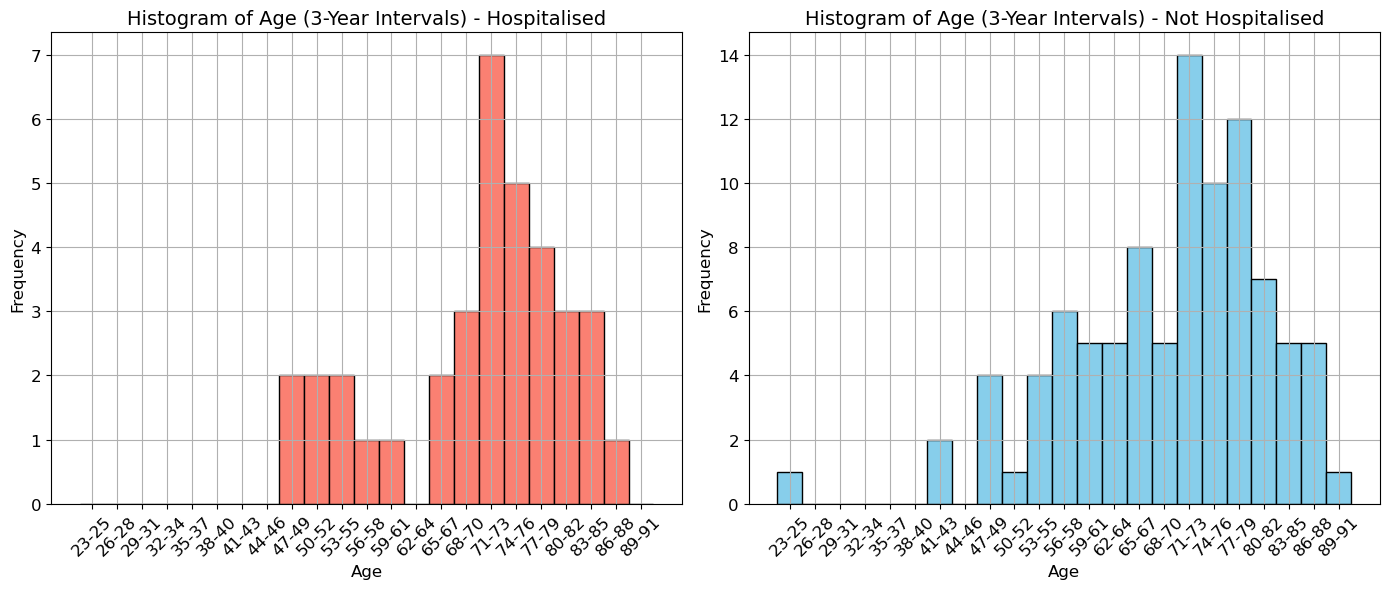

In [56]:
# Define bins for 3-year intervals
min_age = int(df_unique['Age'].min())
max_age = int(df_unique['Age'].max()) + 4  # Adding 3 to include the upper edge of the last bin
bins = list(range(min_age, max_age, 3))  # Create bins with a 3-year interval

# Filter and prepare age data for each group
age_data_group1 = group1['Age'].dropna()
age_data_group2 = group2['Age'].dropna()

# Create histograms
plt.figure(figsize=(14, 6))  # Increase figure size to accommodate two subplots side by side

# Plot histogram for group 1
plt.subplot(1, 2, 1)
counts_group1, edges_group1, patches_group1 = plt.hist(age_data_group1, bins=bins, edgecolor='black', color='salmon')
x_tick_labels_group1 = [f'{edges_group1[i]:.0f}-{edges_group1[i+1] - 1:.0f}' for i in range(len(edges_group1) - 1)]
midpoints_group1 = [(edges_group1[i] + edges_group1[i+1]) / 2 for i in range(len(edges_group1) - 1)]
plt.xticks(ticks=midpoints_group1, labels=x_tick_labels_group1, rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.title('Histogram of Age (3-Year Intervals) - Hospitalised', fontsize=14)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True)

# Plot histogram for group 2
plt.subplot(1, 2, 2)
counts_group2, edges_group2, patches_group2 = plt.hist(age_data_group2, bins=bins, edgecolor='black', color='skyblue')
x_tick_labels_group2 = [f'{edges_group2[i]:.0f}-{edges_group2[i+1] - 1:.0f}' for i in range(len(edges_group2) - 1)]
midpoints_group2 = [(edges_group2[i] + edges_group2[i+1]) / 2 for i in range(len(edges_group2) - 1)]
plt.xticks(ticks=midpoints_group2, labels=x_tick_labels_group2, rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.title('Histogram of Age (3-Year Intervals) - Not Hospitalised', fontsize=14)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

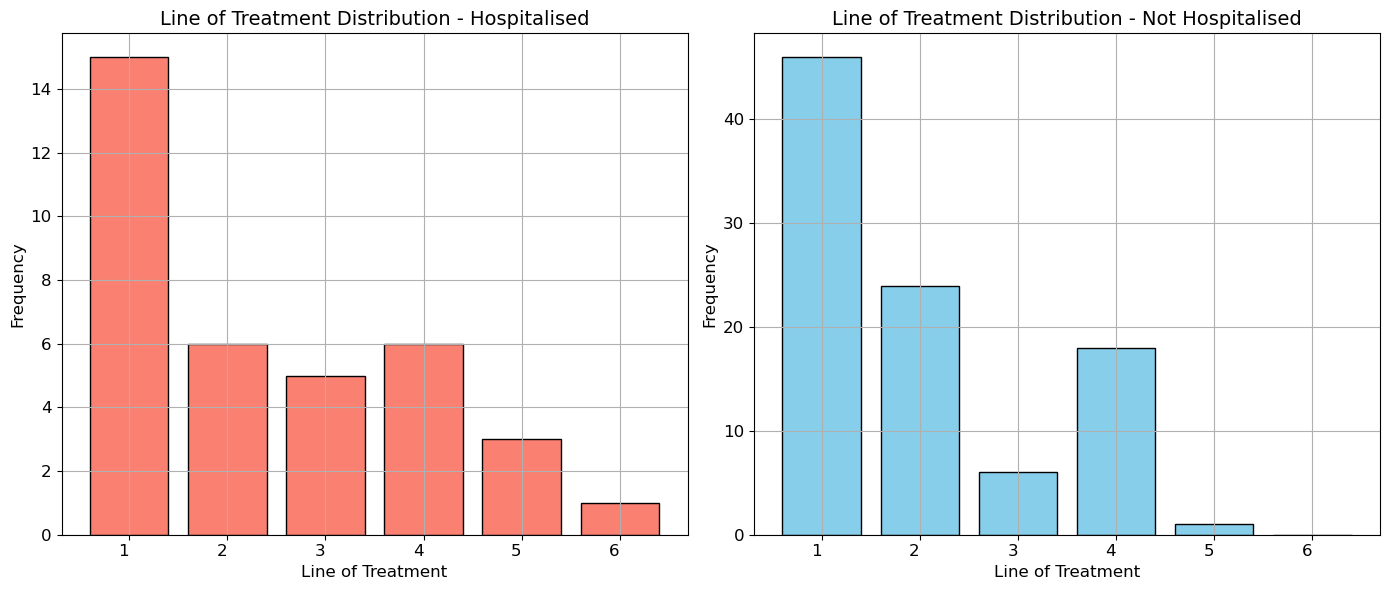

In [57]:
# Prepare the data for plotting
line_of_treatment_counts_group1 = group1['Line of treatment'].value_counts()
line_of_treatment_counts_group2 = group2['Line of treatment'].value_counts()

# Combine all possible treatment lines
all_treatment_lines = sorted(set(line_of_treatment_counts_group1.index) | set(line_of_treatment_counts_group2.index))

# Reindex to ensure all treatment lines are included
line_of_treatment_counts_group1 = line_of_treatment_counts_group1.reindex(all_treatment_lines, fill_value=0)
line_of_treatment_counts_group2 = line_of_treatment_counts_group2.reindex(all_treatment_lines, fill_value=0)

# Create the figure and set up the subplots
plt.figure(figsize=(14, 6))  # Increase figure size to accommodate two subplots side by side

# Plot bar chart for group 1 ('Hospitalised')
plt.subplot(1, 2, 1)
plt.bar(line_of_treatment_counts_group1.index, line_of_treatment_counts_group1.values, color='salmon', edgecolor='black')
plt.title('Line of Treatment Distribution - Hospitalised', fontsize=14)
plt.xlabel('Line of Treatment', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=0, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)

# Plot bar chart for group 2 ('Not Hospitalised')
plt.subplot(1, 2, 2)
plt.bar(line_of_treatment_counts_group2.index, line_of_treatment_counts_group2.values, color='skyblue', edgecolor='black')
plt.title('Line of Treatment Distribution - Not Hospitalised', fontsize=14)
plt.xlabel('Line of Treatment', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=0, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

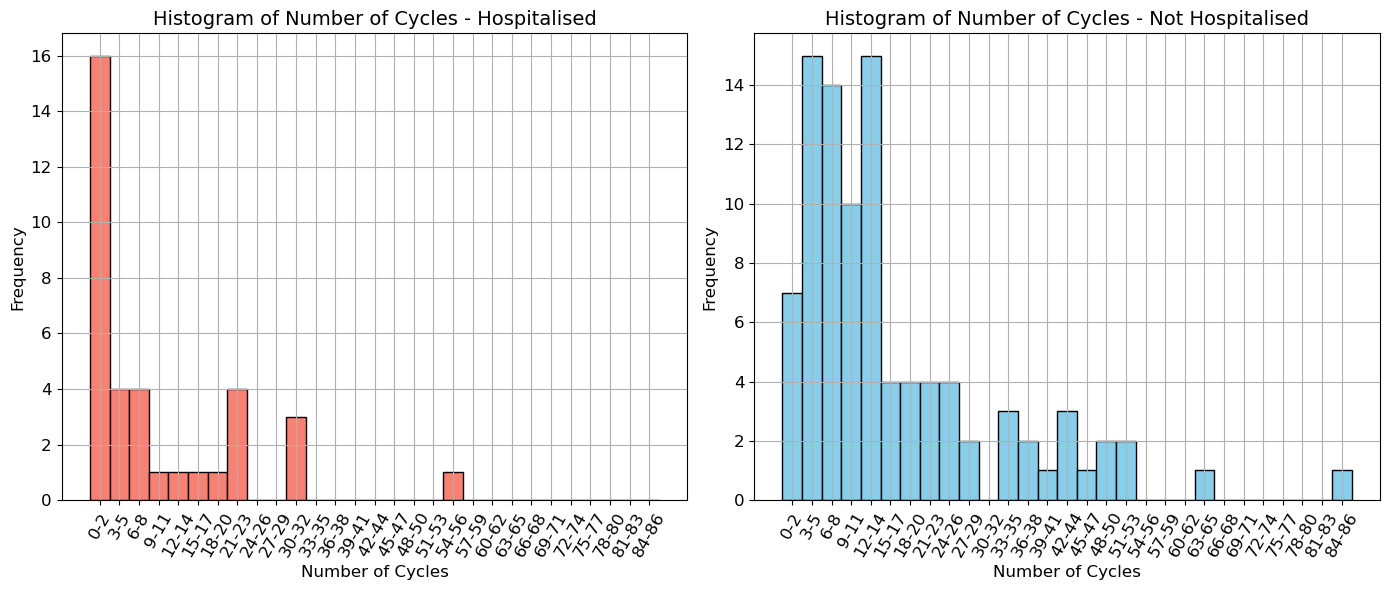

In [58]:
# Define bins for "Number of cycles"
min_cycles = int(df_unique['Number of cycles'].min())
max_cycles = int(df_unique['Number of cycles'].max()) + 4  # Adding 1 to include the upper edge of the last bin
bins = list(range(min_cycles, max_cycles, 3))  # Create bins with a 1-unit interval

# Filter and prepare "Number of cycles" data for each group
cycles_data_group1 = group1['Number of cycles'].dropna()
cycles_data_group2 = group2['Number of cycles'].dropna()

# Create histograms
plt.figure(figsize=(14, 6))  # Increase figure size to accommodate two subplots side by side

# Plot histogram for group 1
plt.subplot(1, 2, 1)
counts_group1, edges_group1, patches_group1 = plt.hist(cycles_data_group1, bins=bins, edgecolor='black', color='salmon')
x_tick_labels_group1 = [f'{edges_group1[i]:.0f}-{edges_group1[i+1] - 1:.0f}' for i in range(len(edges_group1) - 1)]
midpoints_group1 = [(edges_group1[i] + edges_group1[i+1]) / 2 for i in range(len(edges_group1) - 1)]
plt.xticks(ticks=midpoints_group1, labels=x_tick_labels_group1, rotation=60, fontsize=12)
plt.yticks(fontsize=12)
plt.title('Histogram of Number of Cycles - Hospitalised', fontsize=14)
plt.xlabel('Number of Cycles', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True)

# Plot histogram for group 2
plt.subplot(1, 2, 2)
counts_group2, edges_group2, patches_group2 = plt.hist(cycles_data_group2, bins=bins, edgecolor='black', color='skyblue')
x_tick_labels_group2 = [f'{edges_group2[i]:.0f}-{edges_group2[i+1] - 1:.0f}' for i in range(len(edges_group2) - 1)]
midpoints_group2 = [(edges_group2[i] + edges_group2[i+1]) / 2 for i in range(len(edges_group2) - 1)]
plt.xticks(ticks=midpoints_group2, labels=x_tick_labels_group2, rotation=60, fontsize=12)
plt.yticks(fontsize=12)
plt.title('Histogram of Number of Cycles - Not Hospitalised', fontsize=14)
plt.xlabel('Number of Cycles', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

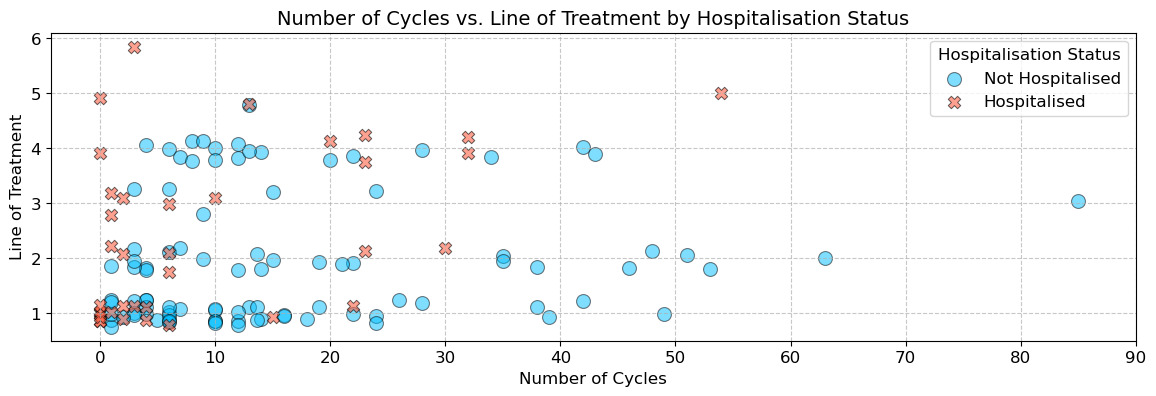

In [59]:
# Set a seed for reproducibility
np.random.seed(14)

# Ensure that the 'Line of treatment' column is numeric
df_unique['Line of treatment'] = pd.to_numeric(df_unique['Line of treatment'], errors='coerce')

# Create jitter for the data
jitter = 0.25

# Apply jitter only to the vertical axis data
df_unique['Number of cycles jittered'] = df_unique['Number of cycles']  # No jitter on horizontal axis
df_unique['Line of treatment jittered'] = df_unique['Line of treatment'] + np.random.uniform(-jitter, jitter, size=len(df_unique))

# Create a scatter plot with jittered points, transparency, and borders
plt.figure(figsize=(14, 4))

# Plot 'Not Hospitalised' points first with jitter, transparency, and borders
sns.scatterplot(
    data=df_unique[df_unique['Hospitalised'] == 0],
    x='Number of cycles jittered',
    y='Line of treatment jittered',
    color='deepskyblue',  # Sky blue color for 'Not Hospitalised'
    s=100,  # Size of the markers
    marker='o',  # Set markers to be circles
    alpha=0.5,  # Add transparency
    edgecolor='black',  # Border color for markers
    label='Not Hospitalised'
)

# Plot 'Hospitalised' points on top with jitter, transparency, and borders
sns.scatterplot(
    data=df_unique[df_unique['Hospitalised'] == 1],
    x='Number of cycles jittered',
    y='Line of treatment jittered',
    color='tomato',  # Salmon color for 'Hospitalised'
    s=80,  # Size of the markers
    marker='X',  # Set markers to be crosses
    alpha=0.6,  # Add transparency
    edgecolor='black',  # Border color for markers
    label='Hospitalised'
)

# Adding labels and title with adjusted font sizes
plt.xlabel('Number of Cycles', fontsize=12)
plt.ylabel('Line of Treatment', fontsize=12)
plt.title('Number of Cycles vs. Line of Treatment by Hospitalisation Status', fontsize=14)

# Adding grid lines
plt.grid(True, linestyle='--', alpha=0.7)  # Customize grid lines (dashed lines with some transparency)

# Set x-axis ticks every 10 units
plt.xticks(ticks=np.arange(df_unique['Number of cycles'].min(), df_unique['Number of cycles'].max() + 10, 10), fontsize=12)

# Adjusting tick label sizes for y-axis
plt.yticks(fontsize=12)

# Show plot with legend
plt.legend(title='Hospitalisation Status', fontsize=12, title_fontsize=12)
plt.show()

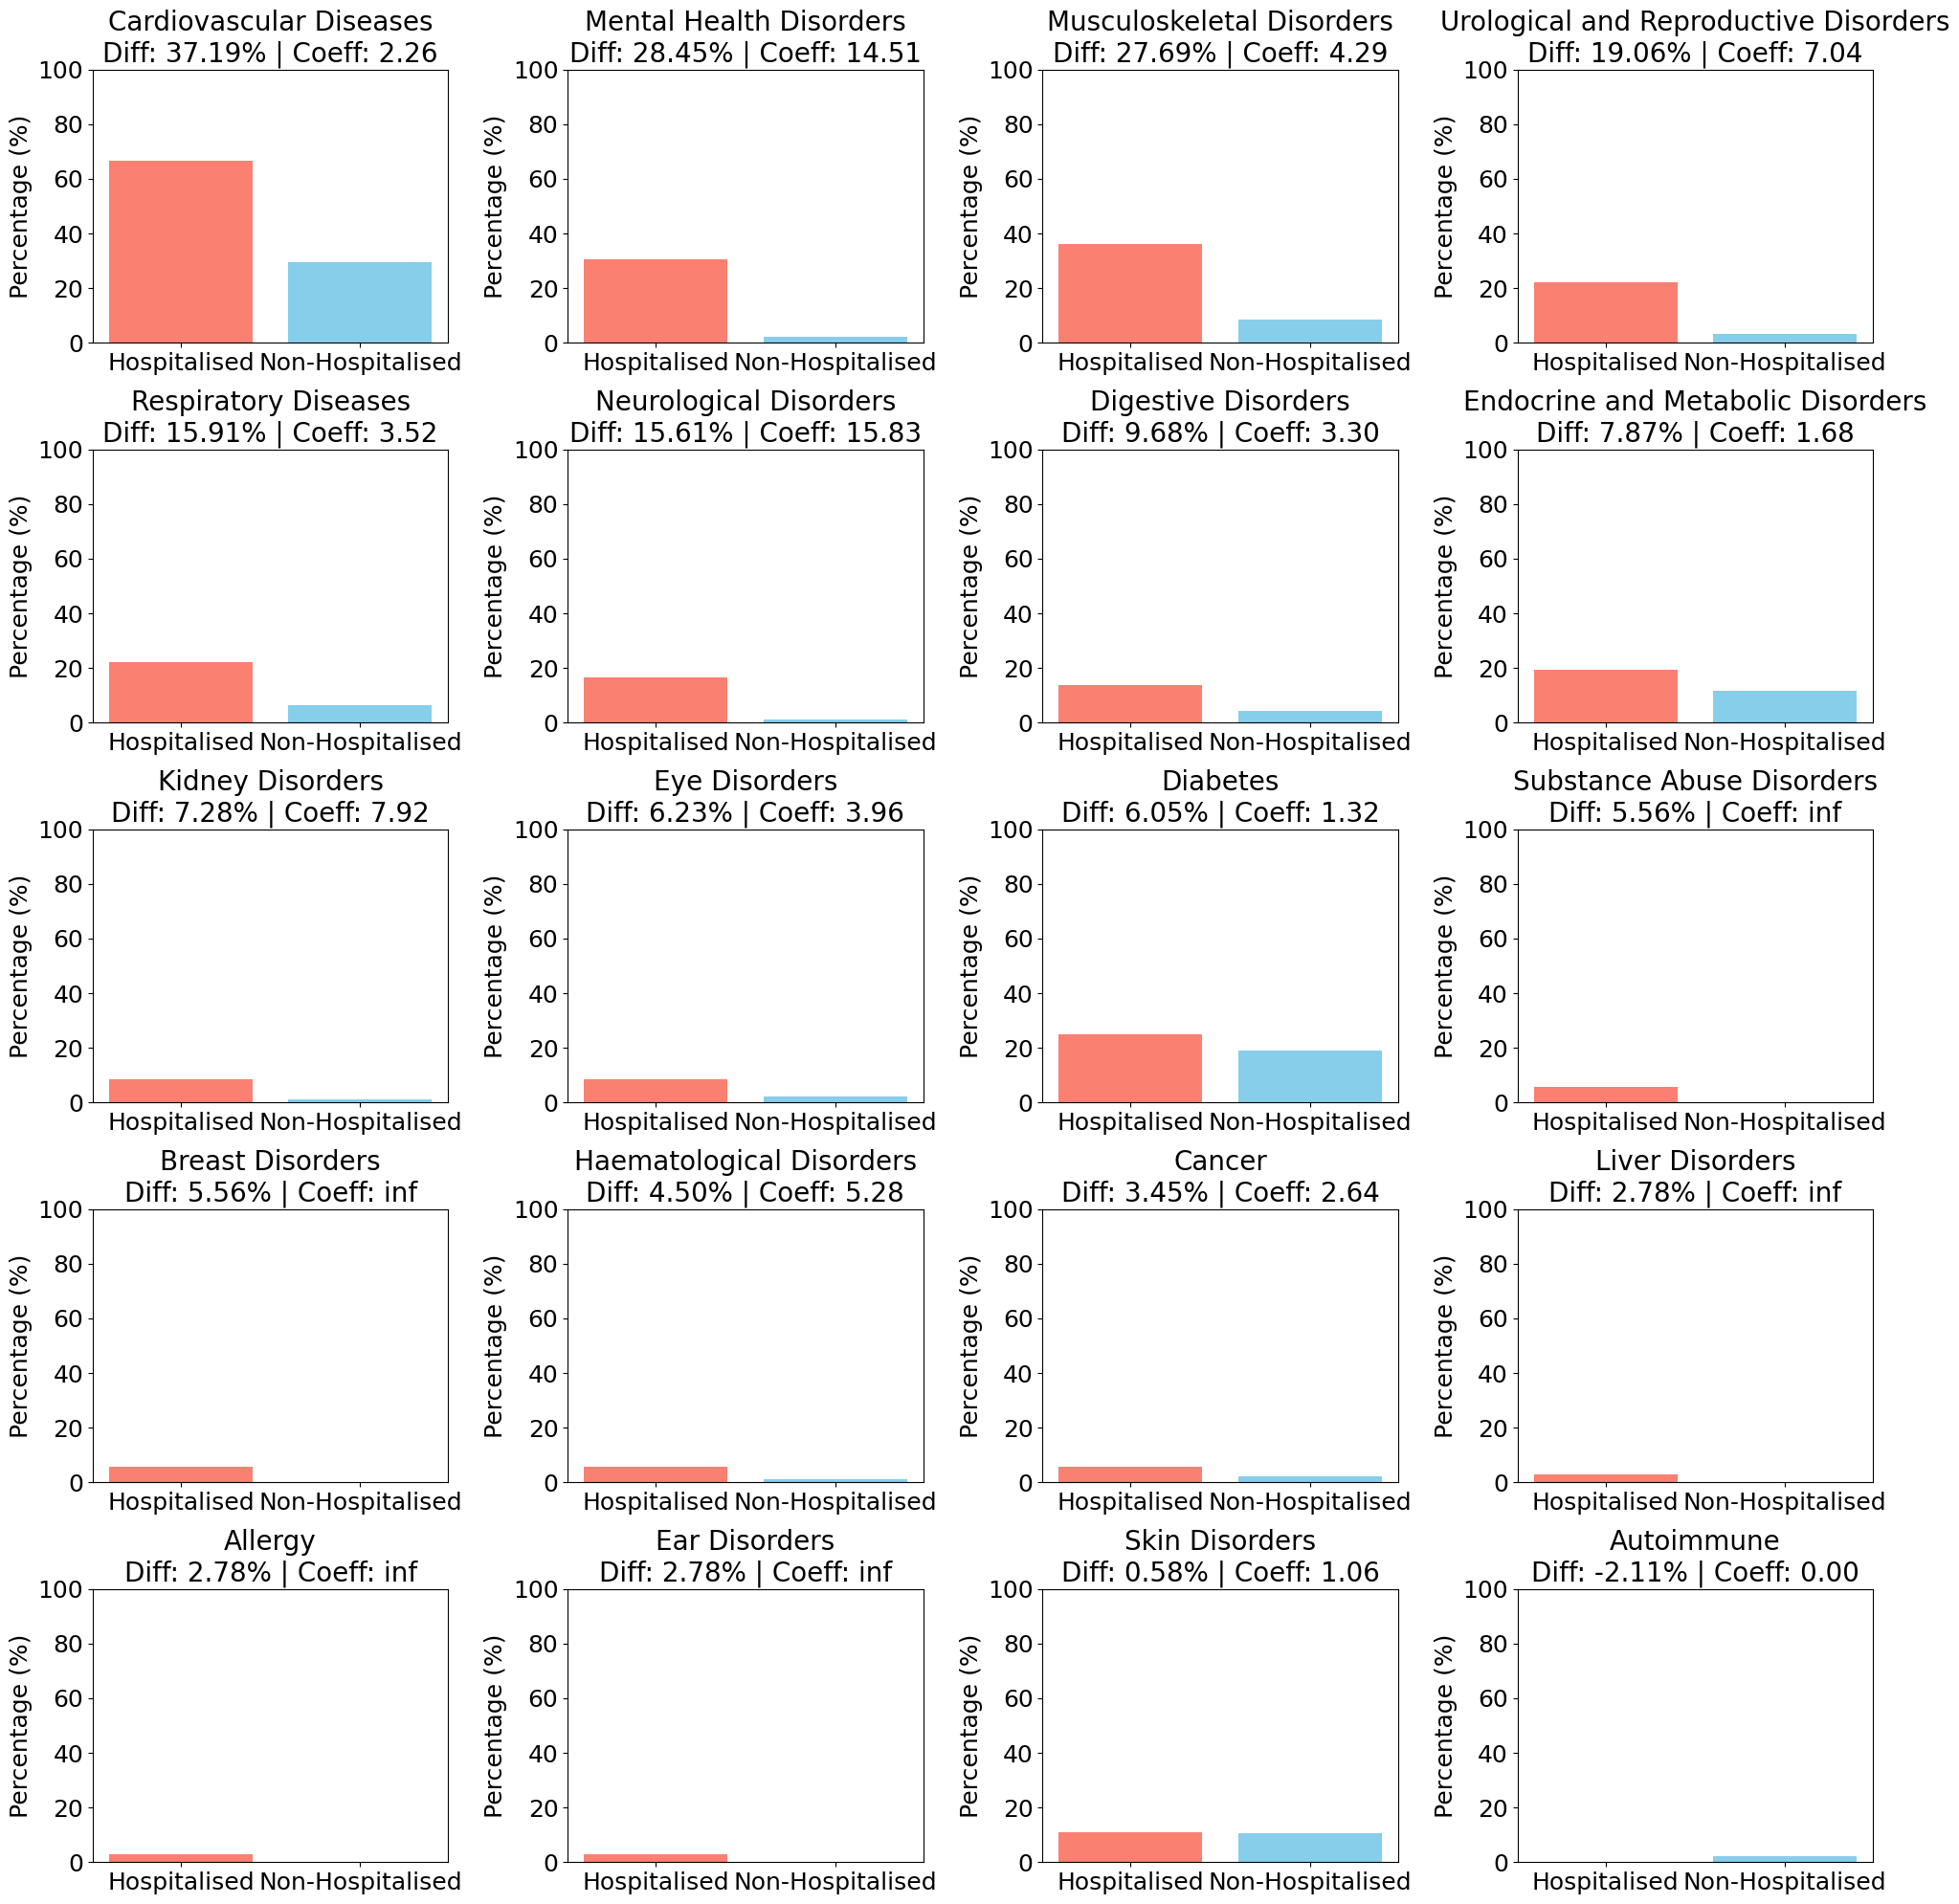

In [60]:
# List of disorders to plot
disorders = [
    'Skin Disorders', 'Endocrine and Metabolic Disorders', 'Urological and Reproductive Disorders', 
    'Cardiovascular Diseases', 'Autoimmune', 'Kidney Disorders', 'Digestive Disorders', 
    'Haematological Disorders', 'Substance Abuse Disorders', 'Eye Disorders', 
    'Respiratory Diseases', 'Liver Disorders', 'Mental Health Disorders', 'Allergy', 
    'Cancer', 'Ear Disorders', 'Diabetes', 'Neurological Disorders', 'Breast Disorders', 
    'Musculoskeletal Disorders']

# Calculate the difference and coefficient for each disorder
differences = {}
coefficients = {}
for disorder in disorders:
    hosp_percent = df_unique[df_unique['Hospitalised'] == 1][disorder].mean() * 100
    non_hosp_percent = df_unique[df_unique['Hospitalised'] == 0][disorder].mean() * 100
    difference = hosp_percent - non_hosp_percent
    coefficient = hosp_percent / non_hosp_percent if non_hosp_percent != 0 else float('inf')
    differences[disorder] = difference
    coefficients[disorder] = coefficient

# Sort disorders by the difference in descending order
sorted_disorders = sorted(differences.keys(), key=lambda x: differences[x], reverse=True)

# Set up the figure with a grid of subplots (5 rows x 4 columns)
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20, 20))
axes = axes.flatten()  # Flatten the 2D array of axes to iterate easily

# Loop through each disorder and create a bar plot in the sorted order
for i, disorder in enumerate(sorted_disorders):
    # Calculate the percentages for hospitalised and non-hospitalised patients
    hosp_percent = df_unique[df_unique['Hospitalised'] == 1][disorder].mean() * 100
    non_hosp_percent = df_unique[df_unique['Hospitalised'] == 0][disorder].mean() * 100
    difference = differences[disorder]
    coefficient = coefficients[disorder]

    # Bar plot for the current disorder
    axes[i].bar(['Hospitalised', 'Non-Hospitalised'], [hosp_percent, non_hosp_percent], color=['salmon', 'skyblue'])
    
    # Set title and labels, including the difference and coefficient in the title
    axes[i].set_title(f'{disorder}\nDiff: {difference:.2f}% | Coeff: {coefficient:.2f}', fontsize=20)
    axes[i].set_ylabel('Percentage (%)', fontsize=18)
    axes[i].set_ylim(0, 100)  # Set y-axis limit to 100% for clarity
    axes[i].tick_params(axis='x', labelsize=18)
    axes[i].tick_params(axis='y', labelsize=18)

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

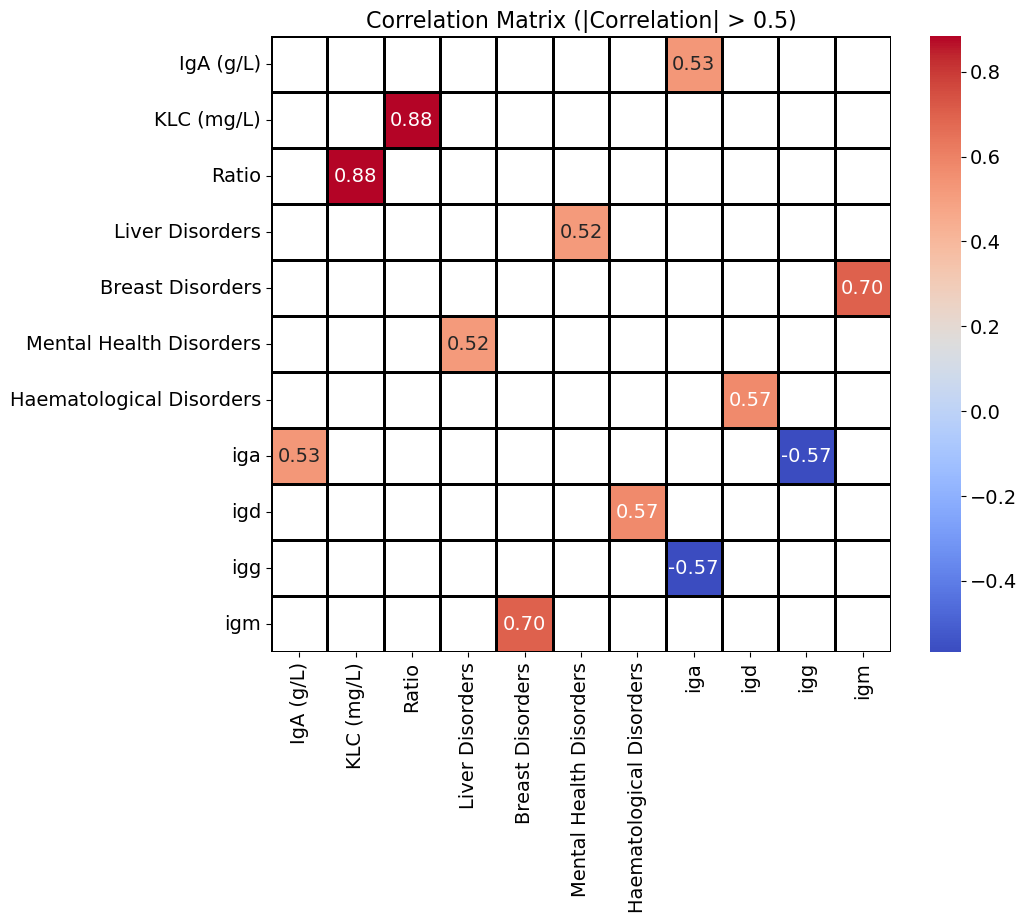

Top positively correlated variable pairs:
                                Variable1                  Variable2  \
0                              KLC (mg/L)                      Ratio   
2                        Breast Disorders                        igm   
4                Haematological Disorders                        igd   
8                                     iga                  IgA (g/L)   
10                Mental Health Disorders            Liver Disorders   
14  Urological and Reproductive Disorders                     Cancer   
16               Haematological Disorders  Substance Abuse Disorders   
18                Mental Health Disorders               Hospitalised   
20                 Neurological Disorders   Haematological Disorders   
22                Cardiovascular Diseases           Breast Disorders   

    Correlation  
0      0.884085  
2      0.701604  
4      0.572892  
8      0.528833  
10     0.515317  
14     0.402824  
16     0.397132  
18     0.392597  
20 

In [61]:
# Step 1: Select All Numeric Columns Except the Ones to be Excluded
# Define columns to exclude
columns_to_exclude = ['Line of treatment jittered', 'Patient Number']

# Select numeric columns only and exclude the specified columns
numeric_columns = df_unique.select_dtypes(include=['number']).columns
columns_to_select = [col for col in numeric_columns if col not in columns_to_exclude]

# Select the corresponding columns from the DataFrame
selected_columns = df_unique[columns_to_select]

# Step 3: Set up the Matplotlib Figure
plt.figure(figsize=(10, 8))

# Compute the Correlation Matrix for the Selected Numeric Columns
correlation_matrix = selected_columns.corr()

# Filter correlations with an absolute value greater than 0.5
high_corr = correlation_matrix[(correlation_matrix.abs() > 0.5) & (correlation_matrix != 1.0)].dropna(how='all', axis=0).dropna(how='all', axis=1)

# Step 4: Draw the Heatmap with the Filtered Correlation Matrix
sns.heatmap(high_corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, annot_kws={"size": 14}, 
            linewidths=1, linecolor='black')

# Set the Title and Labels
plt.title('Correlation Matrix (|Correlation| > 0.5)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Adjust Color Bar Ticks to Match Font Size
cbar = plt.gcf().axes[-1]  # Access the color bar axis
cbar.tick_params(labelsize=14)

# Step 5: Show the Plot
plt.show()


# Define columns to exclude
#columns_to_exclude = ['Line of treatment jittered', 'Patient Number']

# Select numeric columns only and exclude the specified columns
#numeric_columns = df_unique.select_dtypes(include=['number']).columns
#columns_to_select = [col for col in numeric_columns if col not in columns_to_exclude]

#selected_columns = df_unique[columns_to_select]

# Compute the correlation matrix for the selected columns
#correlation_matrix = selected_columns.corr()

# Flatten the correlation matrix and sort by absolute correlation values
corr_pairs = correlation_matrix.unstack()
sorted_corr_pairs = corr_pairs.sort_values(key=lambda x: abs(x), ascending=False)

# Exclude self-correlations
sorted_corr_pairs = sorted_corr_pairs[sorted_corr_pairs != 1]

# Convert to a DataFrame for easier manipulation
sorted_corr_df = sorted_corr_pairs.reset_index()
sorted_corr_df.columns = ['Variable1', 'Variable2', 'Correlation']

# Create a set to keep track of pairs we've seen
seen_pairs = set()

# Filter out duplicates where (A, B) and (B, A) are considered the same
filtered_corr_df = sorted_corr_df[sorted_corr_df.apply(lambda row: (row['Variable1'], row['Variable2']) not in seen_pairs and  not seen_pairs.add((row['Variable2'], row['Variable1'])), axis=1)]

# Select top correlated pairs
top_positive_corr = filtered_corr_df[filtered_corr_df['Correlation'] > 0].head(10)
top_negative_corr = filtered_corr_df[filtered_corr_df['Correlation'] < 0].head(10)

# Print top positive and negative correlated pairs
print("Top positively correlated variable pairs:")
print(top_positive_corr)

print("\nTop negatively correlated variable pairs:")
print(top_negative_corr)

# Model

# Paired t-test to compare means between Hospitalised and Not Hospitalised

In [64]:
# Separate the data into two groups based on 'Hospitalised'
hospitalised_group = df_unique[df_unique['Hospitalised'] == 1]['Number of cycles']
non_hospitalised_group = df_unique[df_unique['Hospitalised'] == 0]['Number of cycles']

hospitalised_group = hospitalised_group.dropna()
non_hospitalised_group = non_hospitalised_group.dropna()

# Conduct a one-tailed independent samples T-Test
# We are testing if the mean of 'hospitalised' is less than 'non_hospitalised'
t_stat, p_value = ttest_ind(hospitalised_group, non_hospitalised_group, alternative='less', equal_var=False)

# Output the results
print(f"One-Tailed Independent Samples T-Test Results:")
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Interpretation with 95% confidence
alpha = 0.05
if p_value < alpha:
    print("With 95% confidence, we reject the null hypothesis and conclude that the mean number of cycles for the hospitalised group is significantly smaller than that of the non-hospitalised group.")
else:
    print("We fail to reject the null hypothesis. There is no significant evidence to suggest that the mean number of cycles for the hospitalised group is smaller than that of the non-hospitalised group.")


# Interpretation with 99% confidence
alpha2 = 0.01
if p_value < alpha2:
    print("With 99% confidence, we reject the null hypothesis and conclude that the mean number of cycles for the hospitalised group is significantly smaller than that of the non-hospitalised group.")
else:
    print("We fail to reject the null hypothesis. There is no significant evidence to suggest that the mean number of cycles for the hospitalised group is smaller than that of the non-hospitalised group.")

One-Tailed Independent Samples T-Test Results:
T-statistic: -2.5491010312235787
P-value: 0.00638144827999505
With 95% confidence, we reject the null hypothesis and conclude that the mean number of cycles for the hospitalised group is significantly smaller than that of the non-hospitalised group.
With 99% confidence, we reject the null hypothesis and conclude that the mean number of cycles for the hospitalised group is significantly smaller than that of the non-hospitalised group.


In [65]:
# Separate the data into two groups based on 'Hospitalised'
hospitalised_group = df_unique[df_unique['Hospitalised'] == 1]['Line of treatment']
non_hospitalised_group = df_unique[df_unique['Hospitalised'] == 0]['Line of treatment']

hospitalised_group = hospitalised_group.dropna()
non_hospitalised_group = non_hospitalised_group.dropna()

# Conduct a one-tailed independent samples T-Test
# We are testing if the mean of 'hospitalised' is less than 'non_hospitalised'
t_stat, p_value = ttest_ind(hospitalised_group, non_hospitalised_group, alternative='two-sided', equal_var=False)

# Output the results
print(f"One-Tailed Independent Samples T-Test Results:")
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Interpretation with 95% confidence
alpha = 0.05
if p_value < alpha:
    print("With 95% confidence, we reject the null hypothesis and conclude that there is a significant difference in the mean number of treatment lines between the hospitalised and non-hospitalised groups.")
else:
    print("We fail to reject the null hypothesis. There is no significant evidence to suggest that there is a difference in the mean number of treatment lines between the hospitalised and non-hospitalised groups.")

One-Tailed Independent Samples T-Test Results:
T-statistic: 1.5200793541843705
P-value: 0.13453607923765584
We fail to reject the null hypothesis. There is no significant evidence to suggest that there is a difference in the mean number of treatment lines between the hospitalised and non-hospitalised groups.


# Log Reg

# Model 1
# 8.1	Hospital Admission Risk Factors Identification

In [68]:
# Step 1: Prepare the Data
# Select relevant features and the target variable
features = df_unique.drop(columns=['Hospitalised', 'Patient Number', 'Ethnicity', 'Line of treatment jittered' ]) #Ethnicity as seen in descriptive analysis is most of one type and little cases of others.
target = df_unique['Hospitalised']

# Encode categorical variables
features = pd.get_dummies(features, drop_first=True)

# Step 2: Initial Logistic Regression Model
log_reg = LogisticRegression(max_iter=1000)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=14)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

# Extract and Display Coefficients
feature_names = features.columns
coefficients = log_reg.coef_[0]
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})
coef_df['Absolute Coefficient'] = coef_df['Coefficient'].abs()
print("Coefficients shape:", coefficients.shape)

# Step 3: Filter Features Based on Coefficients
# Apply the filtering to keep features with absolute coefficients > 0.3
significant_coef_df = coef_df[coef_df['Absolute Coefficient'] > 0.3]
significant_features = significant_coef_df['Feature']

# Ensure only valid features are kept
valid_features = [feature for feature in significant_features if feature in features.columns]
features_filtered = features[valid_features]

# Apply count filter
def count_non_zero_or_false(column):
    if column.dtype == 'object':
        # For categorical columns: count non-'False' values (assuming 'False' as a string)
        return (column != 'False').sum()
    else:
        # For numeric columns: count non-zero values
        return (column != 0).sum()

# Apply the counting function to each feature
row_counts = features_filtered.apply(count_non_zero_or_false)

# Convert row counts to a DataFrame
row_counts_df = pd.DataFrame({'Feature': features_filtered.columns, 'Non-Zero/False Count': row_counts})

# Filter out features with 4 or fewer non-zero/false counts
features_to_keep = row_counts_df[row_counts_df['Non-Zero/False Count'] > 5]['Feature']

# Step 4: Exclude IgG, IgA, and IgM-related Features
exclude_keywords = ['igg', 'iga', 'igm']
final_features = [
    feature for feature in features_to_keep
    if not any(keyword in feature.lower() for keyword in exclude_keywords)
]

# Update the features DataFrame to only include the selected features
features_final = features_filtered[final_features]

# Step 5: Re-Train the Model with Filtered Features
X_train, X_test, y_train, y_test = train_test_split(features_final, target, test_size=0.3, random_state=14)
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Step 6: Evaluate the Model
y_pred = log_reg.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("Accuracy Score:")
print(accuracy_score(y_test, y_pred))

Coefficients shape: (41,)
Classification Report:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        29
           1       1.00      0.45      0.62        11

    accuracy                           0.85        40
   macro avg       0.91      0.73      0.77        40
weighted avg       0.88      0.85      0.83        40

Confusion Matrix:
[[29  0]
 [ 6  5]]
Accuracy Score:
0.85


In [69]:
# Get the final feature names (which should correspond to the model's coefficients)
final_feature_names = features_final.columns  # Should match the number of coefficients

# Get the coefficients from the logistic regression model
coefficients = log_reg.coef_[0]  # Array of 13 coefficients

# Create a DataFrame to display the features and their coefficients
coef_df = pd.DataFrame({
    'Feature': final_feature_names,
    'Coefficient': coefficients
})

# Add a column for the absolute value of coefficients
coef_df['Absolute Coefficient'] = coef_df['Coefficient'].abs()

# Exponentiate the coefficients to get odds ratios
coef_df['Odds Ratio'] = np.exp(coef_df['Coefficient'])

# Count non-zero or non-'False' occurrences in the features_final DataFrame
def count_non_zero_or_false(column):
    if column.dtype == 'object':
        # For categorical columns: count non-'False' values (assuming 'False' as a string)
        return (column != 'False').sum()
    else:
        # For numeric columns: count non-zero values
        return (column != 0).sum()

# Apply the counting function to each feature
row_counts = features_final.apply(count_non_zero_or_false)

# Convert row counts to a DataFrame
row_counts_df = pd.DataFrame({'Feature': features_final.columns, 'Non-Zero/False Count': row_counts})

# Merge row counts with coefficients DataFrame
coef_df = coef_df.merge(row_counts_df, on='Feature', how='left')

# Sort the DataFrame by Odds Ratio to see the most influential features
coef_df = coef_df.sort_values(by='Odds Ratio', ascending=False)

# Display the DataFrame
coef_df

,Feature,Coefficient,Absolute Coefficient,Odds Ratio,Non-Zero/False Count
7,Mental Health Disorders,2.044704,2.044704,7.726870,12
2,Musculoskeletal Disorders,1.490029,1.490029,4.437225,19
5,Cardiovascular Diseases,1.366256,1.366256,3.920644,47
1,Respiratory Diseases,1.079717,1.079717,2.943847,13
3,Neurological Disorders,0.971640,0.971640,2.642275,6
8,Diabetes,0.920323,0.920323,2.510102,27
6,Digestive Disorders,0.889183,0.889183,2.433141,9
9,Urological and Reproductive Disorders,0.714630,0.714630,2.043430,9
4,Endocrine and Metabolic Disorders,0.499939,0.499939,1.648621,17
0,Line of treatment,0.309094,0.309094,1.362191,131


With this I can see what contributes more towards hospitalisation. Now I'll try to create the best model possible to predict hospitalisation.

# Model 2

Precision for the Positive Class
Precision measures the proportion of true positive predictions among all positive predictions made. It is especially useful if you want to minimise false positives (i.e., incorrectly predicting a patient will be hospitalised when they will not).

from sklearn.metrics import make_scorer, precision_score
precision_scorer = make_scorer(precision_score, pos_label=1

Recall for the Positive Class
Recall (or Sensitivity) measures the proportion of actual positives that are correctly identified. It is useful if you want to minimise false negatives (i.e., failing to identify a patient who will be hospitalised).

from sklearn.metrics import make_scorer, recall_score
recall_scorer = make_scorer(recall_score, pos_label=1)F1 Score
F1 Score is the harmonic mean of precision and recall, and provides a single metric that balances both. It is especially useful if you need to balance between precision and recall.

from sklearn.metrics import make_scorer, f1_score
f1_scorer = make_scorer(f1_score, pos_label=1)

)


In [73]:
# Update the features DataFrame to only include the selected features
features_final = features_filtered[final_features]

# Step 3: Split the data
X_train, X_test, y_train, y_test = train_test_split(features_final, target, test_size=0.3, random_state=14)

# Model Selection and Tuning
# Hyperparameter Tuning: Use techniques such as Grid Search or Random Search to find the optimal hyperparameters for your model. For example, tuning regularisation parameters, learning rates, or the number of estimators in ensemble methods.



# Create the F1 scorer with make_scorer, specifying that the positive class (hospitalised) is the one I care about
f1_scorer = make_scorer(f1_score, pos_label=1)

# Example with Logistic Regression
param_grid = {'C': [0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['l1', 'l2', 'elasticnet'], 'solver': ['liblinear', 'saga']}
grid_search = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring=f1_scorer)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

# Step 5: Evaluate the model
y_pred = best_model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("Accuracy Score:")
print(accuracy_score(y_test, y_pred))

# Alternatively, you can manually print out the F1 score, precision, and recall if you prefer:
f1 = f1_score(y_test, y_pred, pos_label=1)
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)

print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Best Parameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Best F1 Score: 0.8166666666666667
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.93      0.92        29
           1       0.80      0.73      0.76        11

    accuracy                           0.88        40
   macro avg       0.85      0.83      0.84        40
weighted avg       0.87      0.88      0.87        40

Confusion Matrix:
[[27  2]
 [ 3  8]]
Accuracy Score:
0.875
F1 Score: 0.7619
Precision: 0.8000
Recall: 0.7273
